# Project: Investigate a Dataset - [European Soccer Database]
by: Mohamed Noaman

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#data_cleaning">Data Cleaning</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### European Soccer Database
<body>
<h4>This is a breif analysis of Kaggle European Soccer Database to investigate european teams statistics in the league between the seasons [ 2008/2009 to 2015/2016 ].
<br>
The main investigations is about the relation between the winning rate and the factors afftecting this rate    
</h4>
<br>
The original data source is provided in sqlite.
I used the uploded csv files on workspace.
</body>

### Questions for Analysis

<h4><p style="color:darkred;">1-Who are the top 10 "Home" winning teams during the seasons [2008/2009] ~ [2015/2016] ?</p></h4> 
<h4><p style="color:darkred;">2-Who are the top 10 "Away" winning teams during the seasons [2008/2009] ~ [2015/2016] ?</p></h4> 
<h4><p style="color:darkred;">3-Who are the top 10 winners teams during the seasons [2008/2009] ~ [2015/2016] ?</p></h4>
<h4><p style="color:darkred;">4-Who are the top 10 highest scoring teams during the seasons [2008/2009] ~ [2015/2016] ?</p></h4> 
<h4><p style="color:darkred;">5-What's the top goal-scored league during the seasons [2008/2009] ~ [2015/2016] ?</p></h4> 
<h4><p style="color:darkred;">6- What are the attributes of the top 10 winners teams ? </p> </h4>
<h4><p style="color:darkred;">7- Who are the Top 10 players that affecting the top 10 winners teams attributes ? </p> </h4>
<h4> To investigate the previous questions I had to answer the following questions: [Top 5 Teams] </h4>

    
<h2>1- ** Teams stats analyzing [Top 10 Teams] during the seasons [2008/2009] ~ [2015/2016] ? ** </h2>
<span>=============================================================================================================</span>
    <h3> Who are the top 10 winners teams? [Top 10 Teams] </h3>
<ul><li><h4>a- Who are the top 10 home winner teams ?  </h4></li>
    <li><h4>b- Who are the top 10 away winner teams ?  </h4></li>
    <li><h4>c- Who are the top 10 overall winner teams ?  </h4></li>
 </ul> 
<h3> What's the top scoring teams? [Top 10 Teams] </h3>
<br> 
<ul><li><h4>A- What is the league with the highest scoring rate  ?  </h4></li>
    <li><h4>B- What's the top home sccorer team ?  </h4></li>
    <li><h4>C- What's the top away sccorer team ?  </h4></li>
    <li><h4>D- What's the most goal-scoring team?  </h4></li>
</ul>
<h3> After getting the top winning teams and the top scoring teams 
     I investigated the previous teams based on the mean of each attribute of: </h3> 
<ul>
    <li><h4>1- Team Defence  </h4>
        <ul>
            <li><h4>Team Width </h4></li>
            <li><h4>Pressure </h4></li>
            <li><h4>Agression </h4></li>
        </ul>
      </li>  
        <br>
    <li><h4>2- Team build-up play  </h4>
        <ul>
            <li><h4> Passing  </h4></li>
            <li><h4>Positioning </h4></li>
            <li><h4>Dribbling </h4></li>
        </ul>             
     </li>
    <li><h4>3- Team chance creation </h4><br>
        <ul>
            <li><h4>Crossing </h4></li>
            <li><h4>Shooting </h4></li>
            <li><h4> Passing  </h4></li>
        </ul>  
    </li>
</ul>
<h2>2- ** Is the scoring rate only affecting the winning rate ? ** </h2> 
<span>=============================================================================================================</span>
 <br>   
<h2>3- ** Which team attributes affecting on the winning rate ? ** </h2>
<span>=============================================================================================================</span>
<br>
<h2>4- ** Players stats analyzing [Top 10 Players] during the during the seasons [2008/2009] ~ [2015/2016]  ** </h2>
<span>=============================================================================================================</span>
<ul><br>
  <li>
     <h3>1- Top Defenders ?</h3>
    <ul>
      <li><h4>a- Top interceptions ?</h4></li>
      <li><h4>b- Top standing tackles ?</h4></li>
      <li><h4>c- Top sliding tackles ?</h4></li>
      <li><h4>d- Top marking ?</h4></li>
    </ul>
  </li> 
  <li>
    <h3>2- Top Build-up Players ?</h3>
    <ul>
      <li><h4>a- Top short passing ?</h4></li>
      <li><h4>b- Top long passing ?</h4></li>
      <li><h4>c- Top positioning ?</h4></li>
    </ul>      
  </li> 
  <li>  
      <h3>3- Top scorer Players ?</h3>
        <ul>
          <li><h4>a- Top heading accuracy ?</h4></li>
          <li><h4>b- Top shot power ?</h4></li>
          <li><h4>c- Top long shots ?</h4></li>
          <li><h4>d- Top finishing ?</h4></li>
        </ul>
   </li>
  <li>
      <h3>4- Top Dribblers ?</h3>
     <ul>
      <li><h4>a- Top heading accuracy ?</h4></li>
      <li><h4>b- Top shot power ?</h4></li>
     </ul>
  </li>
  <li>
      <h3>5- Top Overall players?</h3>
  </li>
</ul>

In [2]:
# Upgrade pandas 
!pip install --upgrade pandas==0.25.0

    100% |████████████████████████████████| 10.5MB 2.6MB/s eta 0:00:01 1% |▋                               | 194kB 8.6MB/s eta 0:00:02    32% |██████████▎                     | 3.4MB 21.5MB/s eta 0:00:01    70% |██████████████████████▌         | 7.3MB 21.3MB/s eta 0:00:01    79% |█████████████████████████▌      | 8.3MB 20.5MB/s eta 0:00:01
    100% |████████████████████████████████| 13.4MB 1.6MB/s eta 0:00:01   13% |████▍                           | 1.8MB 22.3MB/s eta 0:00:01    21% |███████                         | 2.9MB 21.9MB/s eta 0:00:01    29% |█████████▌                      | 4.0MB 22.6MB/s eta 0:00:01    60% |███████████████████▎            | 8.1MB 20.6MB/s eta 0:00:01    94% |██████████████████████████████▏ | 12.6MB 18.1MB/s eta 0:00:01
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
  Found existing installation: numpy 1.12.1
    Uninstalling numpy-1.12.1:
      Successfully uninstalled numpy-1.12.1
  Found existing installation: pand

In [3]:
# !pip install seaborn
!pip3 install seaborn==0.11.0

    100% |████████████████████████████████| 286kB 10.2MB/s ta 0:00:01
    100% |████████████████████████████████| 11.5MB 2.9MB/s eta 0:00:01   11% |███▋                            | 1.3MB 22.9MB/s eta 0:00:01    41% |█████████████▎                  | 4.8MB 25.5MB/s eta 0:00:01    89% |████████████████████████████▊   | 10.4MB 24.2MB/s eta 0:00:01
    100% |████████████████████████████████| 1.1MB 15.8MB/s ta 0:00:01
    100% |████████████████████████████████| 49.4MB 840kB/s eta 0:00:01  0% |▎                               | 419kB 24.3MB/s eta 0:00:03    5% |█▊                              | 2.6MB 23.4MB/s eta 0:00:02    7% |██▌                             | 3.8MB 23.3MB/s eta 0:00:02    14% |████▋                           | 7.1MB 21.5MB/s eta 0:00:02    18% |██████                          | 9.3MB 22.6MB/s eta 0:00:02    20% |██████▊                         | 10.4MB 23.7MB/s eta 0:00:02    23% |███████▍                        | 11.4MB 21.8MB/s eta 0:00:02    24% |████████               

In [4]:
!pip3 install --upgrade matplotlib

Requirement already up-to-date: matplotlib in /opt/conda/lib/python3.6/site-packages (3.3.4)


<a id='wrangling'></a>
## Data Wrangling


### General Properties

#### Import packages

In [5]:
# Use this cell to set up import statements for all of the packages that you plan to use.
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from functools import reduce


### using Pandas to read .csv files as dataframes

In [6]:
country_df = pd.read_csv("./Database_Soccer/Country.csv")
league_df = pd.read_csv("./Database_Soccer/League.csv")
match_df = pd.read_csv("./Database_Soccer/Match.csv")
player_df = pd.read_csv("./Database_Soccer/Player.csv")
player_att_df = pd.read_csv("./Database_Soccer/Player_Attributes.csv")
team_df = pd.read_csv("./Database_Soccer/Team.csv")
team_att_df = pd.read_csv("./Database_Soccer/Team_Attributes.csv")

att = [country_df, league_df, match_df, player_df, player_att_df, team_df, team_att_df]

In [7]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
# country_df.head(1)
# league_df.head(1)
match_df.head(1)
# player_df.tail(1)
# player_att_df.sort_values(by='dribbling', ascending=False).reset_index()
# team_df.head(1)
# team_att_df.info()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.4,4.5,1.78,3.25,4.0,1.73,3.4,4.2


<a id='data_cleaning'></a>
# Data Cleaning



### League dataframe cleaning
#### The only needed columns are the country id and the league name  

1- Delete all columns except the "country_id" and "name" columns  
2- Strip first word in the string to get the league name only

3- Rename the "name" column to "League Name"


In [8]:
league_cols = ['country_id','name']
league_v1_df = league_df.loc[:, league_cols]
league_v1_df['name'] = league_v1_df['name'].apply(lambda x: ' '.join(x.split(' ')[1:]))
league_v1_df.rename(columns = {'name':'League Name'}, inplace=True)

league_v1_df

,country_id,League Name
0,1,Jupiler League
1,1729,Premier League
2,4769,Ligue 1
3,7809,1. Bundesliga
4,10257,Serie A
5,13274,Eredivisie
6,15722,Ekstraklasa
7,17642,Liga ZON Sagres
8,19694,Premier League
9,21518,LIGA BBVA


### Player attributes cleaning

Filtering the player attributes dataframe to the only needed columns:

('player_api_id','penalties','overall_rating','heading_accuracy','shot_power','long_shots','finishing', 'dribbling', 'short_passing', 'long_passing', 'ball_control', 'positioning', 'interceptions',  'standing_tackle','sliding_tackle','marking')


1- Creat list of the needed columns

2- Drop all columns except the columns in the list

3- Check & Drop Null values 

4- Check & Drop Duplicated values

In [9]:
cols = ['player_api_id','penalties','overall_rating','heading_accuracy','shot_power','long_shots','finishing', 'dribbling', 'short_passing', 'long_passing', 'ball_control', 'positioning', 'interceptions',  'standing_tackle','sliding_tackle','marking']
player_att_v1_df = player_att_df.loc[:, cols]

In [10]:
#check null values
player_att_v1_df.isnull().any()

player_api_id       False
penalties            True
overall_rating       True
heading_accuracy     True
shot_power           True
long_shots           True
finishing            True
dribbling            True
short_passing        True
long_passing         True
ball_control         True
positioning          True
interceptions        True
standing_tackle      True
sliding_tackle       True
marking              True
dtype: bool

In [11]:
player_att_v1_df = player_att_v1_df.dropna()

In [12]:
#check null values after cleaning
player_att_v1_df.isnull().any()

player_api_id       False
penalties           False
overall_rating      False
heading_accuracy    False
shot_power          False
long_shots          False
finishing           False
dribbling           False
short_passing       False
long_passing        False
ball_control        False
positioning         False
interceptions       False
standing_tackle     False
sliding_tackle      False
marking             False
dtype: bool

#### clean duplicated values

In [13]:
player_att_v1_df.duplicated().any()

True

In [14]:
player_att_v2_df = player_att_v1_df.drop_duplicates()

In [15]:
player_att_v2_df.duplicated().any()

False

### "Player" dataframe & "Player attributes" dataframe cleaning

To add the player name columns to the "Player attributes" dataframe 
we get player name from "Player" dataframe then we merge it with player attributes based on player id in both df. 

1- In "Player" dataframe, Drop the coloumn except (  'player_api_id','player_name' ) 

2- Check Null & duplicated values

3- Merge (Player) and (Player attributes) dataframes.

In [16]:
# filter player api id and player name only from Player dataframe to be merged later with player attributes dataframe
# to recognize the players name when analyze their attributes. 
cols = ['player_api_id','player_name',]
player_v1_df = player_df.loc[:, cols]

In [17]:
player_v1_df.isnull().any()

player_api_id    False
player_name      False
dtype: bool

In [18]:
player_v1_df.duplicated().any()

False

#### Add the player name to the the player attributes df 
##### by merging it

In [19]:
player_att_clean_df = pd.merge(player_att_v2_df,player_v1_df, left_on='player_api_id', right_on='player_api_id')

In [20]:
#Check the df columns ( Player_name column had been added to the dataframe)
player_att_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109087 entries, 0 to 109086
Data columns (total 17 columns):
player_api_id       109087 non-null int64
penalties           109087 non-null float64
overall_rating      109087 non-null float64
heading_accuracy    109087 non-null float64
shot_power          109087 non-null float64
long_shots          109087 non-null float64
finishing           109087 non-null float64
dribbling           109087 non-null float64
short_passing       109087 non-null float64
long_passing        109087 non-null float64
ball_control        109087 non-null float64
positioning         109087 non-null float64
interceptions       109087 non-null float64
standing_tackle     109087 non-null float64
sliding_tackle      109087 non-null float64
marking             109087 non-null float64
player_name         109087 non-null object
dtypes: float64(15), int64(1), object(1)
memory usage: 15.0+ MB


### Team dataframe cleaning

* Drop all columns except ('team_api_id','team_long_name') to be to be merged later with Team attributes dataframe to recognize the team names when analyze their attributes.

In [21]:
# filter player api id and player name only from Team dataframe to be merged later with Team attributes dataframe
# to recognize the team names when analyze their attributes.
teams_cols = ['team_api_id','team_long_name']
team_v1_df = team_df.loc[:, teams_cols]
team_v1_df.head(1)

,team_api_id,team_long_name
0,9987,KRC Genk


### Match dataframe:

#### The main datafram for our analysis to investigate the top winners and the top scorer teams 

1- Drop unneeded columns in the requested question analysis 

2- check Null & duplicated values 



Calculate the difference between Home goals and Away goals in each match to get the winner of the match

3- Calculate the difference then add the result to a new column (home_goal_diff)

4- To get the winner:
    * Transfer (home_goal_diff) column to "match" list 
    * Iterate "match" list usin an IF loop to check the values in this list and print the result to "winner" list :
        - Positive number = Home team wins
        - Negative number = Away team wins
        - 0  = Draw 
    * replace (home_goal_diff) column's values with "Winner" list values 
5- Rename (home_goal_diff) column to (Winner)

6- Calculate the total goals of each match by adding home and away goal sum to new column (total_goals)

In [22]:
# Drop unneeded columns in the requested question analysis
cols = ['country_id','season','match_api_id','home_team_api_id','away_team_api_id','home_team_goal','away_team_goal']
match_v1_df = match_df.loc[:, cols]
match_v1_df.head(1)

,country_id,season,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,1,2008/2009,492473,9987,9993,1,1


In [23]:
# check for NaN values:
match_v1_df.isnull().any().any()

False

In [24]:
# Check for duplicated values:
match_v1_df.duplicated().any()

False

In [25]:
# get the goal difference to be used to find the winner in each match then add results to new column 
match_v1_df['home_goal_diff'] = match_v1_df['home_team_goal'] - match_v1_df['away_team_goal']

In [26]:
match_v1_df.head()

,country_id,season,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_goal_diff
0,1,2008/2009,492473,9987,9993,1,1,0
1,1,2008/2009,492474,10000,9994,0,0,0
2,1,2008/2009,492475,9984,8635,0,3,-3
3,1,2008/2009,492476,9991,9998,5,0,5
4,1,2008/2009,492477,7947,9985,1,3,-2


#### winners for each match

#### check the winner of each match then append results to new column

In [27]:
winner = []
match_list = match_v1_df['home_goal_diff'].tolist()
for match in match_list:
    if match > 0:
        winner.append('home')
    elif match < 0:
        winner.append('away')
    else:
        winner.append('draw')
        
match_v1_df['home_goal_diff'] = pd.DataFrame(winner)
match_v1_df.head()

,country_id,season,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_goal_diff
0,1,2008/2009,492473,9987,9993,1,1,draw
1,1,2008/2009,492474,10000,9994,0,0,draw
2,1,2008/2009,492475,9984,8635,0,3,away
3,1,2008/2009,492476,9991,9998,5,0,home
4,1,2008/2009,492477,7947,9985,1,3,away


In [28]:
#Double check if there is any duplicated values after last actions
match_v1_df.duplicated().any()

False

In [29]:
#correct the name of the WINNERS column
match_v1_df.rename(columns = {'home_goal_diff':'winner'}, inplace=True)

In [30]:
#Find the total goals for each match to be used later in getting the league with the highest scoring rate
match_v1_df['total_goals'] = match_v1_df['home_team_goal'] + match_v1_df['away_team_goal']

### ============================= Match Dataframe Final =============================

In [31]:
match_v1_df.head()

,country_id,season,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,winner,total_goals
0,1,2008/2009,492473,9987,9993,1,1,draw,2
1,1,2008/2009,492474,10000,9994,0,0,draw,0
2,1,2008/2009,492475,9984,8635,0,3,away,3
3,1,2008/2009,492476,9991,9998,5,0,home,5
4,1,2008/2009,492477,7947,9985,1,3,away,4


<a id='eda'></a>
# ============================================================
# ===================Exploratory Data Analysis====================

=============================================================================================================

## 1- ** Teams stats analyzing [Top 10 Teams] during the seasons [2008/2009] ~ [2015/2016] ? ** 
========================================================



# Top winners per seasons


Who are the top 10 winners teams? [Top 10 Teams] 
a- Who are the top 10 home winner teams ? 
b- Who are the top 10 away winner teams ? 
c- Who are the top 10 overall winner teams ? 

### Home winners
### 1) a- Who are the top 10 home winner teams ?

#### 1- Filter the ''Home'' winners only

* Create a list contains the rows con value (home) in column (winner)
* Transfer the list to datframe to analyize it

In [32]:
home_winner = match_v1_df[match_v1_df['winner'].str.contains('home')]
home_winner_df = pd.DataFrame(home_winner)
home_winner_df.head()

,country_id,season,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,winner,total_goals
3,1,2008/2009,492476,9991,9998,5,0,home,5
8,1,2008/2009,492481,10001,9986,1,0,home,1
9,1,2008/2009,492564,8342,8571,4,1,home,5
21,1,2008/2009,492576,9984,10000,2,0,home,2
25,1,2008/2009,492580,10001,9987,1,0,home,1


### Home winners

#### 2- Top home winners in all seasons
1- Group dataframe with (season) & (home_team_api_id) and count their wins in (winner) column 
    then add it to a new datframe
    
2- Sort the values descending to get the top home winners

3- Rename (home_team_api_id) to (team_api_id) only

4- Rename (winner) to (home_wins)

5- Merge the top_home_winner_season dataframe with (team) dataframe to add team long name 

In [33]:
top_home_winner_season = home_winner_df.groupby(['season','home_team_api_id'])['winner'].count()
top_home_winner_season_df = pd.DataFrame(top_home_winner_season).sort_values(by='winner', ascending=False).reset_index()
top_home_winner_season_df.rename(columns = {'home_team_api_id':'team_api_id','winner':'home_wins'}, inplace=True)
top_home_winner_season_df  = pd.merge(top_home_winner_season_df, team_v1_df, left_on='team_api_id', right_on='team_api_id', how='outer')
top_home_winner_season_df  = top_home_winner_season_df.dropna()
# top_home_winner_season_df = top_home_winner_season_df.drop(columns=['team_api_id'])

In [34]:
top_home_winner_season_df = top_home_winner_season_df.sort_values(by='home_wins', ascending=False)
top_home_winner_season_df.head(10)

,season,team_api_id,home_wins,team_long_name
0,2013/2014,9885,19.0,Juventus
8,2011/2012,8456,18.0,Manchester City
32,2009/2010,8633,18.0,Real Madrid CF
17,2012/2013,8634,18.0,FC Barcelona
16,2009/2010,8634,18.0,FC Barcelona
24,2010/2011,10260,18.0,Manchester United
40,2011/2012,9925,17.0,Celtic
9,2013/2014,8456,17.0,Manchester City
48,2009/2010,8455,17.0,Chelsea
33,2012/2013,8633,17.0,Real Madrid CF


### Top home winners in all seasons during each seaon

1- Create pivot table to get the sum of all home wins of each team in each season

2- Drop Null values 

3- Correct the datatypes on columns to integer

In [35]:
home_winner_df = pd.pivot_table(top_home_winner_season_df, values='home_wins', index='season', columns='team_long_name',
                          aggfunc='sum')

home_winner_df.index.name = None
home_winner_df.columns.name = None
home_winner_v1_df = home_winner_df.transpose()
home_winner_v1_df = home_winner_v1_df.dropna()
home_winner_v1_df['Total_home_wins']= home_winner_v1_df.iloc[:,0:8].sum(axis=1)
home_winner_v1_df= home_winner_v1_df.iloc[0:,0:9].astype(int)

# Research Question 1 
## 1-Who are the top 10 "Home" winning teams during the seasons [2008/2009] ~ [2015/2016] ?¶

### =========================== Top Home Winners =============================


In [36]:
home_winner_v1_df = home_winner_v1_df.sort_values(by='Total_home_wins', ascending=False)
home_winner_v1_df.head(10).style.highlight_max(color = 'lightgreen', axis = 0)

,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016,Total_home_wins
FC Barcelona,14,18,16,17,18,16,16,16,131
Real Madrid CF,14,18,16,16,17,16,16,16,129
Celtic,14,14,15,17,15,16,15,14,120
Manchester United,16,16,18,15,16,9,14,12,116
Manchester City,13,12,13,18,14,17,14,12,113
FC Bayern Munich,12,12,13,14,14,15,14,15,109
Juventus,11,9,8,12,14,19,16,16,105
PSV,11,13,12,15,14,11,16,13,105
Atlético Madrid,13,11,10,11,14,15,14,15,103
FC Basel,12,14,13,13,14,11,12,14,103


In [37]:
# for plotting purpose
home_winner_v2_df = home_winner_v1_df.head(10)
home_winner_v2_df = home_winner_v2_df.reset_index()

### Away  winners
### 1) b- Who are the top 10 away winner teams ?

In [38]:
away_winner = match_v1_df[match_v1_df['winner'].str.contains('away')]
away_winner_df = pd.DataFrame(away_winner)
away_winner_df.head()

,country_id,season,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,winner,total_goals
2,1,2008/2009,492475,9984,8635,0,3,away,3
4,1,2008/2009,492477,7947,9985,1,3,away,4
7,1,2008/2009,492480,4049,9996,1,2,away,3
10,1,2008/2009,492565,9985,9986,1,2,away,3
11,1,2008/2009,492566,10000,9991,0,2,away,2


#### Top away winners in all seasons

1- Group dataframe with (season) & (away_team_api_id) and count their wins in (winner) column 
    then add it to a new datframe
    
2- Sort the values descending to get the top home winners

3- Rename (away_team_api_id) to (team_api_id) only

4- Rename (winner) to (away_wins)

5- Merge the top_away_winner_season dataframe with (team) dataframe to add team long name 

In [39]:
top_away_winner_season = away_winner_df.groupby(['season','away_team_api_id'])['winner'].count()
top_away_winner_season_df = pd.DataFrame(top_away_winner_season).sort_values(by='winner', ascending=False).reset_index()
top_away_winner_season_df.rename(columns = {'away_team_api_id':'team_api_id','winner':'away_wins'}, inplace=True)
top_away_winner_season_df = pd.merge(top_away_winner_season_df, team_v1_df, left_on='team_api_id', right_on='team_api_id', how='outer')
top_away_winner_season_df = top_away_winner_season_df.dropna()
top_away_winner_season_df = top_away_winner_season_df.drop(columns=['team_api_id'])

In [40]:
#sort values by away wins to get the top away winner
top_away_winner_season_df = top_away_winner_season_df.sort_values(by='away_wins', ascending=False)
# top_away_winner_season_df.head(10)

#### Top away winners in all seasons during each seaon


1- Create pivot table to get the sum of all away wins of each team in each season

2- Drop Null values 

3- Correct the datatypes on columns to integer

In [41]:
away_winner_df = pd.pivot_table(top_away_winner_season_df, values='away_wins', index='season', columns='team_long_name',
                          aggfunc='sum')

away_winner_df.index.name = None
away_winner_df.columns.name = None
away_winner_v1_df = away_winner_df.transpose()
away_winner_v1_df = away_winner_v1_df.dropna()
away_winner_v1_df['Total_away_wins']= away_winner_v1_df.iloc[:,0:8].sum(axis=1)
away_winner_v1_df= away_winner_v1_df.iloc[0:,0:9].astype(int)

# Research Question 2 

## 2-Who are the top 10 "Away" winning teams during the seasons [2008/2009] ~ [2015/2016] ?

### ============================= Top Away Winners =============================


In [42]:
away_winner_v1_df = away_winner_v1_df.sort_values(by='Total_away_wins', ascending=False)
away_winner_v1_df.head(15).style.highlight_max(color = 'lightgreen', axis = 0)

,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016,Total_away_wins
FC Barcelona,13,13,14,11,14,11,14,13,103
Real Madrid CF,11,13,13,16,9,11,14,12,99
Celtic,10,11,14,13,9,15,14,12,98
FC Bayern Munich,8,8,6,9,15,14,11,13,84
Juventus,10,7,7,10,13,14,10,13,84
SL Benfica,8,10,9,7,12,11,12,14,83
FC Porto,12,9,13,10,10,6,10,11,81
Ajax,8,11,9,11,11,7,9,12,78
FC Basel,10,11,8,9,7,8,12,12,77
Manchester United,12,11,5,13,12,10,6,7,76


# Top overall winners

### 1) c- Who are the top 10 overall winner teams ? 

#### prepare the list of top winner to be used later in comparing teams with each others based on this order

#### Gather Top home winners & Top away winners to get the overall winner teams

In [43]:
home_winner_v2_df = home_winner_v1_df.reset_index()
home_winner_cols = ['index','Total_home_wins']
home_winner_v3_df = home_winner_v2_df.loc[:, home_winner_cols]

In [44]:
away_winner_v2_df = away_winner_v1_df.reset_index()
away_winner_cols = ['index','Total_away_wins']
away_winner_v3_df = away_winner_v2_df.loc[:, away_winner_cols]

### Top overall winners

In [45]:
top_winner_season_df = pd.merge(home_winner_v3_df, away_winner_v3_df, left_on=['index'], right_on=['index'], how='outer')
top_winner_season_df['Total_wins'] = top_winner_season_df['Total_away_wins'] + top_winner_season_df['Total_home_wins']
top_winner_season_df  = top_winner_season_df.sort_values(by='Total_wins', ascending=False)
top_winner_season_df  = top_winner_season_df.dropna()
top_winner_season_df = top_winner_season_df.set_index('index')
top_winner_season_df.index.name ='Team Name'
top_winner_season_df = top_winner_season_df.iloc[0:,0:3].astype(int)

# Research Question 3 
## 3-Who are the top 10 winners teams during the seasons [2008/2009] ~ [2015/2016] ?

### ============================== Top Winners =============================


In [46]:
top_winner_season_v1_df = top_winner_season_df.head(10)
top_winner_season_v1_df.style.background_gradient(text_color_threshold=0.408)

,Total_home_wins,Total_away_wins,Total_wins
Team Name,,,
FC Barcelona,131,103,234
Real Madrid CF,129,99,228
Celtic,120,98,218
FC Bayern Munich,109,84,193
Manchester United,116,76,192
Juventus,105,84,189
SL Benfica,102,83,185
FC Porto,102,81,183
Ajax,103,78,181


In [47]:
#prepare for plotting
top_winner_season_v2_df = top_winner_season_v1_df.reset_index()

## The most scoring teams
<body>
<h3>Analysis steps are: </h3>
<h4>1- Create new dataframe by grouping match dataframe by home teams and their home goals in each macth as home team
    + then rename home team id as team id only  </h4>
<h4>2- Create new dataframe by grouping match dataframe by away teams and their away goals in each macth as away team
    + then rename home team id as team id only  </h4>
<h4>3- Merge both new dataframe and based on 'team_api_id' as index  </h4>
<h4>4- Sum (Home) and (Away) goals for each team and create new column named (total_goals)
    + then drop "(Home) & (Away)" goals columns </h4>
<h4>5- Sort teams by total goals </h4>
<h4>6- Select the top 10 teams only </h4>
</body>

######  =============================================
###### What's the top scoring teams? [Top 10 Teams] 

###### A- What is the league with the highest scoring rate ? 
###### B- What's the top home sccorer team ? 
###### C- What's the top away sccorer team ? 
###### D- What's the most goal-scoring team? 

###  The most scoring teams [HOME]

In [48]:
home_total_goals = match_v1_df.groupby(['home_team_api_id'])['home_team_goal'].sum()
home_total_goals_df = pd.DataFrame(home_total_goals).sort_values(by='home_team_goal', ascending=False).reset_index()
home_total_goals_df.rename(columns = {'home_team_api_id':'team_api_id'}, inplace=True)

In [49]:
home_total_goals_v1_df = pd.merge(home_total_goals_df, team_v1_df, left_on='team_api_id', right_on='team_api_id', how='outer')
home_total_goals_v1_df = home_total_goals_v1_df.drop(columns=['team_api_id'])
# home_total_goals_v1_df.head(10)

###  The most scoring teams [AWAY]

In [50]:
away_total_goals = match_v1_df.groupby(['away_team_api_id'])['away_team_goal'].sum()
away_total_goals_df = pd.DataFrame(away_total_goals).sort_values(by='away_team_goal', ascending=False).reset_index()
away_total_goals_df.rename(columns = {'away_team_api_id':'team_api_id'}, inplace=True)

In [51]:
away_total_goals_v1_df = pd.merge(away_total_goals_df, team_v1_df, left_on='team_api_id', right_on='team_api_id', how='outer')
away_total_goals_v1_df = away_total_goals_v1_df.drop(columns=['team_api_id'])
# away_total_goals_v1_df.head(10)

## ===========================Top Scorer Teams============================ 

In [52]:
total_goals_df = pd.merge(home_total_goals_v1_df, away_total_goals_v1_df, left_on=['team_long_name'], right_on=['team_long_name'], how='outer')
total_goals_df['total_goals'] = total_goals_df['home_team_goal'] + total_goals_df['away_team_goal']
total_goals_df = total_goals_df.drop(columns=['home_team_goal', 'away_team_goal'])
# total_goals_df = pd.merge(total_goals_df, team_v1_df, left_on='team_api_id', right_on='team_api_id', how='outer')
total_goals_df = total_goals_df.dropna()
total_goals_df = total_goals_df.sort_values(by='total_goals', ascending=False).head(15)

In [53]:
# cleaning for plotting
total_goals_df.style.background_gradient(text_color_threshold=0.408)
top_scorer = pd.DataFrame(total_goals_df.head(10))
top_scorer.rename(columns = {'team_long_name':'Team Name','total_goals':'Total Goals'}, inplace=True)

## Total goals per season

<body>
<h3>Analysis steps are: </h3>
<h4>Same previous steps except group match dataframe by "Home & Away" teams + "Season"  </h4>
</body>

In [54]:
home_goals_by_year = match_v1_df.groupby(['season','home_team_api_id'])['home_team_goal'].sum()
home_goals_by_year_df = pd.DataFrame(home_goals_by_year).sort_values(by='home_team_goal', ascending=False).reset_index()
home_goals_by_year_df.rename(columns = {'home_team_api_id':'team_api_id'}, inplace=True)
# home_goals_by_year_df.head(10)

In [55]:
away_goals_by_year = match_v1_df.groupby(['season','away_team_api_id'])['away_team_goal'].sum()
away_goals_by_year_df = pd.DataFrame(away_goals_by_year).sort_values(by='away_team_goal', ascending=False).reset_index()
away_goals_by_year_df.rename(columns = {'away_team_api_id':'team_api_id'}, inplace=True)
# away_goals_by_year_df.head(10)

In [56]:
goals_by_year_df = pd.merge(home_goals_by_year_df, away_goals_by_year_df, left_on=['team_api_id','season'], right_on=['team_api_id','season'], how='outer')
goals_by_year_df['total_goals_year'] = goals_by_year_df['home_team_goal'] + goals_by_year_df['away_team_goal']
goals_by_year_df = goals_by_year_df.drop(columns=['home_team_goal', 'away_team_goal'])
# goals_by_year_df

In [57]:
top_winner_season_v1_df

,Total_home_wins,Total_away_wins,Total_wins
Team Name,,,
FC Barcelona,131,103,234
Real Madrid CF,129,99,228
Celtic,120,98,218
FC Bayern Munich,109,84,193
Manchester United,116,76,192
Juventus,105,84,189
SL Benfica,102,83,185
FC Porto,102,81,183
Ajax,103,78,181


In [58]:
goals_by_v1_year_df = pd.merge(goals_by_year_df, team_v1_df, left_on='team_api_id', right_on='team_api_id', how='inner')
goals_by_v1_year_df = pd.DataFrame(goals_by_v1_year_df)
goals_by_v1_year_df.rename(columns = {'team_long_name':'Team Name'}, inplace=True)
goals_by_v1_year_df = goals_by_v1_year_df.sort_values(by='total_goals_year', ascending=False)
# goals_by_v1_year_df = goals_by_year_df.set_index('team_long_name')
# goals_by_v1_year_df
# goals_by_v1_year_df

In [59]:
goals_by_v2_year_df = pd.merge(goals_by_v1_year_df, top_winner_season_v2_df, left_on='Team Name', right_on='Team Name', how='right')
goals_by_v3_year_df = goals_by_v2_year_df.drop(columns=['Total_home_wins', 'Total_away_wins','team_api_id'])

goals_by_v4_year_df = goals_by_v3_year_df.drop(columns=['Total_wins'])
# goals_by_v4_year_df

# Research Question 4
## 4-Who are the top 10 highest scoring teams during the seasons [2008/2009] ~ [2015/2016] ?

In [60]:
total_goal_per_season = pd.pivot_table(goals_by_v3_year_df, values='total_goals_year', index='season', columns=['Team Name','Total_wins'],
                          aggfunc='sum')
total_goal_per_season = total_goal_per_season.transpose()
total_goal_per_season.columns.name = None
total_goal_per_season_v1 = total_goal_per_season.reset_index()
total_goal_per_season_v1 = total_goal_per_season_v1.sort_values(by='Total_wins', ascending=False)\
# total_goal_per_season_v1

In [61]:
#prepare for plotting
total_goal_per_season_v2 = total_goal_per_season_v1.drop(columns=['Total_wins'])
total_goal_per_season_v2 = total_goal_per_season_v2.set_index('Team Name')
total_goal_per_season_v2 = total_goal_per_season_v2.transpose()

### Total goals per seasons


##### Top winner teams kept their scoring rate high.

In [62]:
total_goal_per_season_v2.style.highlight_max(color = 'lightgreen', axis = 1)

Team Name,FC Barcelona,Real Madrid CF,Celtic,FC Bayern Munich,Manchester United,Juventus,SL Benfica,FC Porto,Ajax,FC Basel
2008/2009,105,83,80,71,68,69,54,61,74,72
2009/2010,98,102,75,72,86,55,78,70,106,90
2010/2011,95,102,85,81,78,57,61,73,72,76
2011/2012,114,121,84,77,89,64,66,69,93,78
2012/2013,115,103,92,98,86,71,77,70,83,61
2013/2014,100,104,102,94,64,80,58,57,69,70
2014/2015,110,118,84,80,62,72,86,74,69,84
2015/2016,112,110,93,80,49,75,88,67,81,88


## Top 10 seasons with most goal scored

In [63]:
goals_by_year_v2 = goals_by_v4_year_df.groupby(['season','Team Name'])['total_goals_year'].sum()
goals_by_year_v2_df = pd.DataFrame(goals_by_year_v2).sort_values(by='total_goals_year', ascending=False).reset_index()
goals_by_year_v2_df.head(10).style.background_gradient(text_color_threshold=0.408)

,season,Team Name,total_goals_year
0,2011/2012,Real Madrid CF,121
1,2014/2015,Real Madrid CF,118
2,2012/2013,FC Barcelona,115
3,2011/2012,FC Barcelona,114
4,2015/2016,FC Barcelona,112
5,2015/2016,Real Madrid CF,110
6,2014/2015,FC Barcelona,110
7,2009/2010,Ajax,106
8,2008/2009,FC Barcelona,105
9,2013/2014,Real Madrid CF,104


In [64]:
# prepare for plotting
total_goals_sum = total_goal_per_season_v2.cumsum();

# Research Question 5
## Top league with the highest scoring rate
### 5 - What's the top goal-scored league during the seasons [2008/2009] ~ [2015/2016] ?

In [65]:
league_season_df = pd.DataFrame(match_v1_df.groupby(['country_id','season'])['total_goals'].sum()).reset_index()

In [66]:
total_goal_league_season_df = pd.merge(league_v1_df, league_season_df, left_on=('country_id'), right_on=('country_id'), how='outer')
total_league_goals_df = pd.DataFrame(total_goal_league_season_df.groupby('League Name')['total_goals'].sum())
total_league_goals_df = total_league_goals_df.sort_values(by='total_goals', ascending=False)

In [67]:
total_league_goals_df = total_league_goals_df.reset_index()
total_league_goals_df.rename(columns = {'total_goals':'Total Goals'}, inplace=True)

total_league_goals_df.style.background_gradient(text_color_threshold=0.408)

,League Name,Total Goals
0,Premier League,13044
1,LIGA BBVA,8412
2,Serie A,7895
3,Eredivisie,7542
4,Ligue 1,7427
5,1. Bundesliga,7103
6,Liga ZON Sagres,5201
7,Jupiler League,4841
8,Ekstraklasa,4656
9,Super League,4166


### ===================================================================================
# Team Attributes:
### The attributes that affecting on the winning and the scoring rate


<ul>       
    <li><h5>1- Team Defence  </h5><br>
        <ul>
            <li> Team Width </li>
            <li> Pressure </li>
        </ul>                    
    <li><h5>2- Team build-up  </h5><br>
        <ul>
            <li>  Passing  </li>
            <li> Positioning </li>
        </ul>             
     </li>
    <li><h5>3- Team chance creation </h5><br>
        <ul>
            <li> Crossing </li>
            <li> Shooting </li>
        </ul>              
     </li>
</ul>

### Team Attributes dataframe:


In [68]:
top_winner_season_v1_df.head(10)

,Total_home_wins,Total_away_wins,Total_wins
Team Name,,,
FC Barcelona,131,103,234
Real Madrid CF,129,99,228
Celtic,120,98,218
FC Bayern Munich,109,84,193
Manchester United,116,76,192
Juventus,105,84,189
SL Benfica,102,83,185
FC Porto,102,81,183
Ajax,103,78,181


In [69]:
team_v1_df.head(10)

,team_api_id,team_long_name
0,9987,KRC Genk
1,9993,Beerschot AC
2,10000,SV Zulte-Waregem
3,9994,Sporting Lokeren
4,9984,KSV Cercle Brugge
5,8635,RSC Anderlecht
6,9991,KAA Gent
7,9998,RAEC Mons
8,7947,FCV Dender EH
9,9985,Standard de Liège


In [70]:
top_winner_season_v3_df = top_winner_season_v1_df.copy(deep=True)
top_winner_season_v3_df = top_winner_season_v3_df.reset_index()
top_winner_season_v3_df.rename(columns = {'Team Name':'team_long_name'}, inplace=True)
top_winner_season_v3_df = pd.DataFrame(top_winner_season_v3_df)
top_winner_season_v3_df

,team_long_name,Total_home_wins,Total_away_wins,Total_wins
0,FC Barcelona,131,103,234
1,Real Madrid CF,129,99,228
2,Celtic,120,98,218
3,FC Bayern Munich,109,84,193
4,Manchester United,116,76,192
5,Juventus,105,84,189
6,SL Benfica,102,83,185
7,FC Porto,102,81,183
8,Ajax,103,78,181
9,FC Basel,103,77,180


In [71]:
team_v1_df
winner_att = pd.merge(team_v1_df, top_winner_season_v3_df, left_on=('team_long_name'), right_on=('team_long_name'), how='right')
winner_att

,team_api_id,team_long_name,Total_home_wins,Total_away_wins,Total_wins
0,10260,Manchester United,116,76,192
1,9823,FC Bayern Munich,109,84,193
2,9885,Juventus,105,84,189
3,8593,Ajax,103,78,181
4,9773,FC Porto,102,81,183
5,9772,SL Benfica,102,83,185
6,9925,Celtic,120,98,218
7,8633,Real Madrid CF,129,99,228
8,8634,FC Barcelona,131,103,234
9,9931,FC Basel,103,77,180


In [72]:
winner_att_v1 = pd.merge(team_att_df, winner_att, left_on=('team_api_id'), right_on=('team_api_id'), how='right')
winner_att_v1 = winner_att_v1.drop(columns=['id','team_fifa_api_id','date','Total_home_wins','Total_away_wins'])

#### After noticing that all null values in 'buildUpPlayDribbling' == 'Little' in buildUpPlayDribblingClass which is less than 33
so it can be filled with the mean between (1:30)  

In [73]:
list_a = list(range(33))
mean_min= np.mean(list_a)
mean_min

16.0

In [74]:
winner_att_v1 = winner_att_v1.fillna(mean_min)
winner_att_v1.buildUpPlayDribbling = winner_att_v1.buildUpPlayDribbling.astype(int)

In [75]:
#to check that team name added in the dataframe and the datatype od dribbling is integer

winner_att_v1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 24 columns):
team_api_id                       60 non-null int64
buildUpPlaySpeed                  60 non-null int64
buildUpPlaySpeedClass             60 non-null object
buildUpPlayDribbling              60 non-null int64
buildUpPlayDribblingClass         60 non-null object
buildUpPlayPassing                60 non-null int64
buildUpPlayPassingClass           60 non-null object
buildUpPlayPositioningClass       60 non-null object
chanceCreationPassing             60 non-null int64
chanceCreationPassingClass        60 non-null object
chanceCreationCrossing            60 non-null int64
chanceCreationCrossingClass       60 non-null object
chanceCreationShooting            60 non-null int64
chanceCreationShootingClass       60 non-null object
chanceCreationPositioningClass    60 non-null object
defencePressure                   60 non-null int64
defencePressureClass              60 non-null object
defe

# Research Question 6
## 6- What are the attributes of the top 10 winners teams ?

### 1- Team Defence ¶

###### a- Pressure mean
###### b- Team Width mean
###### c- Aggression mean

### 2- Team build-up 

###### a- Passing mean
###### b- Positioning mean
###### c- Dribbling mean

### 3- Team chance creation 

###### a- Crossing mean
###### b- Shooting mean
###### c- Passing mean

In [76]:
### Analysis steps are

### For each attribute I used pivot technique to get the values of each attributes and its class based on each team 
### Then merge it with the top winners dataframe to filter the attributes of the top winners only 


### 1- Team Defence  

###   a- Top teams defence (Pressure) mean

In [77]:
team_att_pressure_df = pd.pivot_table(winner_att_v1, values='defencePressure', index='team_long_name', columns='defencePressureClass',
                          aggfunc='mean')
team_att_pressure_df.columns.name = None
team_att_pressure_df = pd.DataFrame(team_att_pressure_df)
team_att_pressure_df = team_att_pressure_df.fillna(0).reset_index()
team_att_pressure_df

,team_long_name,Deep,High,Medium
0,Ajax,30.0,68.0,64.333333
1,Celtic,0.0,0.0,53.333333
2,FC Barcelona,0.0,68.5,62.250000
3,FC Basel,0.0,0.0,47.666667
4,FC Bayern Munich,0.0,71.0,50.250000
5,FC Porto,30.0,0.0,58.000000
6,Juventus,23.0,0.0,48.200000
7,Manchester United,0.0,0.0,45.000000
8,Real Madrid CF,0.0,68.0,48.800000
9,SL Benfica,30.0,0.0,59.200000


In [78]:
team_att_pressure_v1_df = pd.merge(team_att_pressure_df, winner_att, left_on=('team_long_name'), right_on=('team_long_name'), how='inner')
team_att_pressure_v1_df = team_att_pressure_v1_df.drop(columns=['Total_home_wins','Total_away_wins','team_api_id'])
team_att_pressure_v1_df = team_att_pressure_v1_df.set_index(['team_long_name','Total_wins'])
team_att_pressure_v1_df = team_att_pressure_v1_df.sort_values(by='Total_wins', ascending=False)
team_att_pressure_v1_df = team_att_pressure_v1_df.iloc[0:,0:3].astype(int)
team_att_pressure_v1_df = team_att_pressure_v1_df.reset_index()


In [79]:
team_att_pressure_v1_df.style.background_gradient(text_color_threshold=0.408)

,team_long_name,Total_wins,Deep,High,Medium
0,FC Barcelona,234,0,68,62
1,Real Madrid CF,228,0,68,48
2,Celtic,218,0,0,53
3,FC Bayern Munich,193,0,71,50
4,Manchester United,192,0,0,45
5,Juventus,189,23,0,48
6,SL Benfica,185,30,0,59
7,FC Porto,183,30,0,58
8,Ajax,181,30,68,64
9,FC Basel,180,0,0,47


In [80]:
#prepare for plotting
team_att_pressure_v2_df = team_att_pressure_v1_df
team_att_pressure_v2_df.rename(columns = {'team_long_name':'Team Name'}, inplace=True)

### 1)  b- Top teams defence (Team Width) mean

In [81]:
team_att_teamwidth_df = pd.pivot_table(winner_att_v1, values='defenceTeamWidth', index='team_long_name', columns='defenceTeamWidthClass',
                          aggfunc='mean')
team_att_teamwidth_df.columns.name = None
team_att_teamwidth_df = pd.DataFrame(team_att_teamwidth_df)
team_att_teamwidth_df = team_att_teamwidth_df.fillna(0).reset_index()
# team_att_teamwidth_df.style.highlight_max(color = 'lightgreen', axis = 0)

In [82]:
team_att_teamwidth_v1_df = pd.merge(team_att_teamwidth_df, winner_att, left_on=('team_long_name'), right_on=('team_long_name'), how='outer')
team_att_teamwidth_v1_df = team_att_teamwidth_v1_df.drop(columns=['Total_home_wins','Total_away_wins','team_api_id'])
team_att_teamwidth_v1_df = team_att_teamwidth_v1_df.sort_values(by='Total_wins', ascending=False)
team_att_teamwidth_v2_df = team_att_teamwidth_v1_df.set_index(['team_long_name','Total_wins'])
team_att_teamwidth_v2_df = team_att_teamwidth_v2_df.iloc[0:,0:4].astype(int)

In [83]:
team_att_teamwidth_v2_df.style.background_gradient(text_color_threshold=0.408)

,,Narrow,Normal,Wide
team_long_name,Total_wins,,,
FC Barcelona,234,0,65,69
Real Madrid CF,228,0,62,68
Celtic,218,0,59,68
FC Bayern Munich,193,0,55,0
Manchester United,192,0,54,0
Juventus,189,0,35,70
SL Benfica,185,30,56,0
FC Porto,183,30,60,0
Ajax,181,30,59,0


### 1)  3- Top teams defence (Aggression) mean

In [84]:
team_att_aggression_df = pd.pivot_table(winner_att_v1, values='defenceAggression', index='team_long_name', columns='defenceAggressionClass',
                          aggfunc='mean')
team_att_aggression_df.columns.name = None
team_att_aggression_df = pd.DataFrame(team_att_aggression_df)
team_att_aggression_df = team_att_aggression_df.fillna(0).reset_index()
# team_att_aggression_df.style.highlight_max(color = 'lightgreen', axis = 0)
team_att_aggression_df

,team_long_name,Contain,Double,Press
0,Ajax,30.0,0.0,58.600000
1,Celtic,0.0,70.0,51.200000
2,FC Barcelona,30.0,0.0,59.400000
3,FC Basel,0.0,0.0,57.500000
4,FC Bayern Munich,0.0,0.0,48.833333
5,FC Porto,30.0,0.0,54.400000
6,Juventus,0.0,67.0,52.500000
7,Manchester United,0.0,0.0,48.000000
8,Real Madrid CF,0.0,0.0,52.166667
9,SL Benfica,30.0,0.0,55.800000


In [85]:
team_att_aggression_v1_df = pd.merge(team_att_aggression_df, winner_att, left_on=('team_long_name'), right_on=('team_long_name'), how='inner')
team_att_aggression_v1_df = team_att_aggression_v1_df.drop(columns=['Total_home_wins','Total_away_wins','team_api_id'])
team_att_aggression_v1_df = team_att_aggression_v1_df.sort_values(by='Total_wins', ascending=False)
team_att_aggression_v2_df = team_att_aggression_v1_df.set_index(['team_long_name','Total_wins'])
team_att_aggression_v2_df = team_att_aggression_v2_df.iloc[0:,0:4].astype(int)
team_att_aggression_v2_df.sort_values(by='Total_wins', ascending=False).style.background_gradient(text_color_threshold=0.408)
team_att_aggression_v2_df

,,Contain,Double,Press
team_long_name,Total_wins,,,
FC Barcelona,234,30,0,59
Real Madrid CF,228,0,0,52
Celtic,218,0,70,51
FC Bayern Munich,193,0,0,48
Manchester United,192,0,0,48
Juventus,189,0,67,52
SL Benfica,185,30,0,55
FC Porto,183,30,0,54
Ajax,181,30,0,58


In [86]:
#prepare for ploting
team_att_aggression_v3_df = team_att_aggression_v2_df.reset_index()
team_att_aggression_v3_df.rename(columns = {'team_long_name':'Team Name'}, inplace=True)
team_att_aggression_v3_df

,Team Name,Total_wins,Contain,Double,Press
0,FC Barcelona,234,30,0,59
1,Real Madrid CF,228,0,0,52
2,Celtic,218,0,70,51
3,FC Bayern Munich,193,0,0,48
4,Manchester United,192,0,0,48
5,Juventus,189,0,67,52
6,SL Benfica,185,30,0,55
7,FC Porto,183,30,0,54
8,Ajax,181,30,0,58
9,FC Basel,180,0,0,57


## 2- Team build-up ¶

### a- Top teams build-up (Passing) mean

In [87]:
team_att_passing_df = pd.pivot_table(winner_att_v1, values='buildUpPlayPassing', index='team_long_name', columns='buildUpPlayPassingClass',
                          aggfunc='mean')
team_att_passing_df.columns.name = None
team_att_passing_df = pd.DataFrame(team_att_passing_df)
team_att_passing_df = team_att_passing_df.fillna(mean_min).reset_index()
# team_att_passing_df.style.highlight_max(color = 'lightgreen', axis = 1)

In [88]:
team_att_passing_v1_df = pd.merge(team_att_passing_df, winner_att, left_on=('team_long_name'), right_on=('team_long_name'), how='inner')
team_att_passing_v1_df = team_att_passing_v1_df.drop(columns=['Total_home_wins','Total_away_wins','team_api_id'])
# team_att_passing_v1_df = team_att_passing_v1_df.set_index('team_long_name')
team_att_passing_v1_df['Total Passes'] = team_att_passing_v1_df['Short'] + team_att_passing_v1_df['Mixed'] + team_att_passing_v1_df['Long']
team_att_passing_v1_df = team_att_passing_v1_df.sort_values(by='Total_wins', ascending=False)
team_att_passing_v2_df = team_att_passing_v1_df.set_index(['team_long_name','Total_wins'])

In [89]:
team_att_passing_v2_df.head(15).style.background_gradient(text_color_threshold=0.408)

,,Long,Mixed,Short,Total Passes
team_long_name,Total_wins,,,,
FC Barcelona,234,16,42.5,29.75,88.25
Real Madrid CF,228,16,40.4,30,86.4
Celtic,218,70,54.8,16,140.8
FC Bayern Munich,193,16,40.25,25,81.25
Manchester United,192,16,45.8333,16,77.8333
Juventus,189,16,40,25.6667,81.6667
SL Benfica,185,16,48.6,30,94.6
FC Porto,183,16,52.4,30,98.4
Ajax,181,16,38.5,31.5,86


In [90]:
#prepare for plotting
team_att_passing_v3_df = team_att_passing_v2_df.reset_index()
team_att_passing_v3_df.rename(columns = {'team_long_name':'Team Name'}, inplace=True)
# team_att_passing_v3_df.style.background_gradient(text_color_threshold=0.408)

### 2) b- Top teams build-up play positioning mean

#### Group each team positioning for each team

### *socre out of 6

In [91]:
overall_positionin_df = pd.DataFrame(winner_att_v1.groupby(['team_long_name'])['buildUpPlayPositioningClass'].value_counts())
overall_positionin_df.rename(columns = {'buildUpPlayPositioningClass':'overall'}, inplace=True)
overall_positionin_df.head(5).style.highlight_max(color = 'lightgreen', axis = 1)

In [92]:
att_positioning_df = pd.pivot_table(overall_positionin_df, values='overall', index='team_long_name', columns='buildUpPlayPositioningClass',
                          aggfunc='mean')
att_positioning_df.columns.name = None
att_positioning_df = att_positioning_df.fillna(0)
att_positioning_df = pd.DataFrame(att_positioning_df)
att_positioning_df = att_positioning_df.reset_index()
att_positioning_df = pd.merge(att_positioning_df, winner_att, left_on=('team_long_name'), right_on=('team_long_name'), how='outer')
att_positioning_df = att_positioning_df.drop(columns=['Total_home_wins','Total_away_wins','team_api_id'])
att_positioning_df = att_positioning_df.sort_values(by='Total_wins', ascending=False)
att_positioning_v1_df = att_positioning_df.set_index(['team_long_name','Total_wins'])
att_positioning_v1_df = att_positioning_v1_df.iloc[0:,0:2].astype(int)

In [93]:
# prepare for plotting
att_positioning_v1_df
att_positioning_v2_df = att_positioning_v1_df.reset_index()
att_positioning_v2_df.rename(columns = {'team_long_name':'Team Name'}, inplace=True)
att_positioning_v2_df.style.background_gradient(text_color_threshold=0.408)

,Team Name,Total_wins,Free Form,Organised
0,FC Barcelona,234,6,0
1,Real Madrid CF,228,4,2
2,Celtic,218,0,6
3,FC Bayern Munich,193,3,3
4,Manchester United,192,0,6
5,Juventus,189,1,5
6,SL Benfica,185,2,4
7,FC Porto,183,1,5
8,Ajax,181,3,3
9,FC Basel,180,0,6


### 2) c-  Top winners teams "Build-up Play Dribbling" mean

In [94]:
team_dribbling_df = pd.pivot_table(winner_att_v1, values='buildUpPlayDribbling', index='team_long_name', columns='buildUpPlayDribblingClass',
                          aggfunc='mean')
team_dribbling_df.columns.name = None
team_dribbling_df = pd.DataFrame(team_dribbling_df).reset_index()
# team_dribbling_df.style.background_gradient(text_color_threshold=0.408)

In [95]:
team_dribbling_v1_df = pd.merge(team_dribbling_df, winner_att, left_on=('team_long_name'), right_on=('team_long_name'), how='inner')
team_dribbling_v1_df = team_dribbling_v1_df.drop(columns=['Total_home_wins','Total_away_wins','team_api_id'])
team_dribbling_v1_df = team_dribbling_v1_df.sort_values(by='Total_wins', ascending=False)
team_dribbling_v2_df = team_dribbling_v1_df.set_index(['team_long_name','Total_wins'])

In [96]:
#prepare for ploting
team_dribbling_v3_df = team_dribbling_v2_df.reset_index()
team_dribbling_v3_df.rename(columns = {'team_long_name':'Team Name'}, inplace=True)
team_dribbling_v3_df.style.background_gradient(text_color_threshold=0.400)

,Team Name,Total_wins,Little,Normal
0,FC Barcelona,234,16,35
1,Real Madrid CF,228,16,55.5
2,Celtic,218,16,50.5
3,FC Bayern Munich,193,17.6,34
4,Manchester United,192,16,38
5,Juventus,189,16,41
6,SL Benfica,185,16,55
7,FC Porto,183,16,50
8,Ajax,181,16,41.5
9,FC Basel,180,16,63


## 3- Team chance creation ¶

### a-  Top winners teams "Chance Creation by Crossing " mean

In [97]:
team_crossing_df = pd.pivot_table(winner_att_v1, values='chanceCreationCrossing', index='team_long_name', columns='chanceCreationCrossingClass',
                          aggfunc='mean')
team_crossing_df.columns.name = None
team_crossing_df = pd.DataFrame(team_crossing_df)
team_crossing_df = team_crossing_df.fillna(mean_min).reset_index()

In [98]:
team_crossing_v1_df = pd.merge(team_crossing_df, winner_att, left_on=(['team_long_name']), right_on=(['team_long_name']), how='inner')
team_crossing_v1_df = team_crossing_v1_df.sort_values(by='Total_wins', ascending=False)
team_crossing_v1_df = team_crossing_v1_df.drop(columns=['Total_home_wins','Total_away_wins','team_api_id'])
team_crossing_v1_df = team_crossing_v1_df.set_index(['team_long_name','Total_wins'])
team_crossing_v1_df = team_crossing_v1_df.iloc[:, [0, 2, 1]]

team_crossing_v1_df.style.background_gradient(text_color_threshold=0.400)

,,Little,Normal,Lots
team_long_name,Total_wins,,,
FC Barcelona,234,27.75,44.5,16
Real Madrid CF,228,16,53.8333,16
Celtic,218,16,57,68.5
FC Bayern Munich,193,30.6667,41,70
Manchester United,192,16,56.3333,70
Juventus,189,16,57.2,77
SL Benfica,185,16,59,16
FC Porto,183,16,64.25,72
Ajax,181,16,58.5,16


In [99]:
#prepare for plotting
team_crossing_v2_df = team_crossing_v1_df.reset_index()
team_crossing_v2_df.rename(columns = {'team_long_name':'Team Name'}, inplace=True)

### 3) b- Top winners teams "Chance Creation by Shooting " mean

In [100]:
team_shooting_df = pd.pivot_table(winner_att_v1, values='chanceCreationShooting', index='team_long_name', columns='chanceCreationShootingClass',
                          aggfunc='mean')
team_shooting_df.columns.name = None
team_shooting_df = pd.DataFrame(team_shooting_df)
team_shooting_df = team_shooting_df.fillna(mean_min).reset_index()

In [101]:
team_shooting_v1_df = pd.merge(team_shooting_df, winner_att, left_on=('team_long_name'), right_on=('team_long_name'), how='inner')
team_shooting_v1_df = team_shooting_v1_df.drop(columns=['Total_home_wins','Total_away_wins','team_api_id'])
team_shooting_v2_df = team_shooting_v1_df.set_index(['team_long_name','Total_wins'])
team_shooting_v2_df = team_shooting_v2_df.sort_values(by='Total_wins', ascending=False)
team_shooting_v2_df = team_shooting_v2_df.iloc[:, [0, 2, 1]]

team_shooting_v2_df = team_shooting_v2_df.iloc[0:,0:3].astype(int)

In [102]:
team_shooting_v2_df.style.background_gradient(text_color_threshold=0.400)

,,Little,Normal,Lots
team_long_name,Total_wins,,,
FC Barcelona,234,16,45,69
Real Madrid CF,228,16,63,70
Celtic,218,16,59,70
FC Bayern Munich,193,22,44,71
Manchester United,192,16,50,70
Juventus,189,16,50,73
SL Benfica,185,16,55,16
FC Porto,183,16,62,68
Ajax,181,30,43,68


In [103]:
team_shooting_v3_df = team_shooting_v2_df.reset_index()
team_shooting_v3_df = team_shooting_v3_df.sort_values(by='Total_wins', ascending=False)
team_shooting_v3_df.rename(columns = {'team_long_name':'Team Name'}, inplace=True)

### 3) c- Top winners teams "Chance Creation by Passing " mean

In [104]:
team_att_chance_passing_df = pd.pivot_table(winner_att_v1, values='chanceCreationPassing', index='team_long_name', columns='chanceCreationPassingClass',
                          aggfunc='mean')
team_att_chance_passing_df.columns.name = None
team_att_chance_passing_df = pd.DataFrame(team_att_chance_passing_df)
team_att_chance_passing_df = team_att_chance_passing_df.fillna(mean_min).reset_index()
# team_att_chance_passing_df.style.highlight_max(color = 'lightgreen', axis = 1)

In [105]:
team_att_chance_passing_v1_df = pd.merge(team_att_chance_passing_df, winner_att, left_on=('team_long_name'), right_on=('team_long_name'), how='inner')
team_att_chance_passing_v1_df = team_att_chance_passing_v1_df.drop(columns=['Total_home_wins','Total_away_wins','team_api_id'])
team_att_chance_passing_v1_df['Total Passes'] = team_att_chance_passing_v1_df['Safe'] + team_att_chance_passing_v1_df['Normal'] + team_att_chance_passing_v1_df['Risky']
team_att_chance_passing_v1_df = team_att_chance_passing_v1_df.sort_values(by='Total_wins', ascending=False)
team_att_chance_passing_v2_df = team_att_chance_passing_v1_df.set_index(['team_long_name','Total_wins'])
team_att_chance_passing_v2_df = team_att_chance_passing_v2_df.iloc[0:,0:4].astype(int)
team_att_chance_passing_v2_df = team_att_chance_passing_v2_df.iloc[:, [2, 0, 1,3]]


In [106]:
team_att_chance_passing_v2_df.head(15).style.background_gradient(text_color_threshold=0.408)

,,Safe,Normal,Risky,Total Passes
team_long_name,Total_wins,,,,
FC Barcelona,234,16,45,16,77
Real Madrid CF,228,16,61,68,145
Celtic,218,16,55,16,87
FC Bayern Munich,193,21,42,16,79
Manchester United,192,16,50,16,82
Juventus,189,16,56,16,88
SL Benfica,185,16,61,69,146
FC Porto,183,16,55,16,87
Ajax,181,16,47,67,130


In [107]:
#prepare for ploting
team_att_chance_passing_v3_df = team_att_chance_passing_v2_df.reset_index()
team_att_chance_passing_v3_df.rename(columns = {'team_long_name':'Team Name'}, inplace=True)
team_att_chance_passing_v3_df = team_att_chance_passing_v3_df.sort_values(by='Total_wins', ascending=False)

# Research Question 6
## 7- Who are the Top 10 players that affecting the top 10 winners teams attributes ?

## a -  Top Defenders

In [108]:
top_interceptions = player_att_clean_df.groupby('player_name')['interceptions'].mean()
top_interceptions_df = pd.DataFrame(top_interceptions)
top_interceptions_df = top_interceptions_df.sort_values(by='interceptions', ascending=False)

In [109]:
top_standing_tackle = player_att_clean_df.groupby('player_name')['standing_tackle'].mean()
top_standing_tackle_df = pd.DataFrame(top_standing_tackle)
top_standing_tackle_df = top_standing_tackle_df.sort_values(by='standing_tackle', ascending=False)

In [110]:
top_sliding_tackle = player_att_clean_df.groupby('player_name')['sliding_tackle'].mean()
top_sliding_tackle_df = pd.DataFrame(top_sliding_tackle)
top_sliding_tackle_df = top_sliding_tackle_df.sort_values(by='sliding_tackle', ascending=False)

In [111]:
top_marking = player_att_clean_df.groupby('player_name')['marking'].mean()
top_marking_df = pd.DataFrame(top_marking)
top_marking_df = top_marking_df.sort_values(by='marking', ascending=False)

In [112]:
data_frames = [top_interceptions_df, top_sliding_tackle_df, top_standing_tackle_df,top_marking_df]
df_defender = reduce(lambda  left,right: pd.merge(left,right,on=['player_name'],
                                            how='outer'), data_frames)

df_defender = reduce(lambda  left,right: pd.merge(left,right,on=['player_name'],
                                            how='outer'), data_frames).fillna(0)
df_defender.head()

,interceptions,sliding_tackle,standing_tackle,marking
player_name,,,,
Javier Mascherano,90.705882,88.882353,90.882353,82.823529
Carles Puyol,90.090909,89.181818,89.636364,90.636364
Philipp Lahm,89.772727,94.363636,87.454545,85.636364
Gary Neville,89.000000,83.000000,83.833333,81.666667
Andrea Barzagli,87.741935,84.806452,87.225806,86.612903


In [113]:
df_defender['Overall Defending'] = (df_defender['standing_tackle'] + df_defender['interceptions'] + df_defender['sliding_tackle']+df_defender['standing_tackle'] )/4 

In [114]:
df_defender = df_defender.sort_values(by='Overall Defending', ascending=False)
df_defender.head(10).style.background_gradient(text_color_threshold=0.408)

,interceptions,sliding_tackle,standing_tackle,marking,Overall Defending
player_name,,,,,
Javier Mascherano,90.7059,88.8824,90.8824,82.8235,90.3382
Philipp Lahm,89.7727,94.3636,87.4545,85.6364,89.7614
Carles Puyol,90.0909,89.1818,89.6364,90.6364,89.6364
Giorgio Chiellini,86.8276,88.3448,88.7586,88.4828,88.1724
John Terry,85,85.5625,89.625,87.375,87.4531
Sergio Ramos,83.4286,89,87.7857,85,87
Andrea Barzagli,87.7419,84.8065,87.2258,86.6129,86.75
Thiago Silva,83.8947,88.2632,87.0526,85.3684,86.5658
Gennaro Gattuso,84.3846,85.6923,87.3077,79.6154,86.1731


In [115]:
df_defender_v1 = df_defender.head(10).reset_index()

## b-  Top Build-up Players

In [116]:
top_short_passing = player_att_clean_df.groupby('player_name')['short_passing'].mean()
top_short_passing_df = pd.DataFrame(top_short_passing)
top_short_passing_df = top_short_passing_df.sort_values(by='short_passing', ascending=False)

In [117]:
top_long_passing = player_att_clean_df.groupby('player_name')['long_passing'].mean()
top_long_passing_df = pd.DataFrame(top_long_passing)
top_long_passing_df = top_long_passing_df.sort_values(by='long_passing', ascending=False)

In [118]:
top_positioning = player_att_clean_df.groupby('player_name')['positioning'].mean()
top_positioning_df = pd.DataFrame(top_positioning)
top_positioning_df = top_positioning_df.sort_values(by='positioning', ascending=False)

In [119]:
data_frames_v2 = [top_short_passing_df, top_long_passing_df,top_positioning_df]
df_buildUp = reduce(lambda  left,right: pd.merge(left,right,on=['player_name'],
                                            how='outer'), data_frames_v2)

df_buildUp = reduce(lambda  left,right: pd.merge(left,right,on=['player_name'],
                                            how='outer'), data_frames_v2).fillna(0)


In [120]:
df_buildUp['Overall Build_up'] = (df_buildUp['short_passing'] + df_buildUp['long_passing'] + df_buildUp['positioning'] )/3


In [121]:
df_buildUp = df_buildUp.sort_values(by='Overall Build_up', ascending=False)

df_buildUp.head(10).style.background_gradient(text_color_threshold=0.408)

,short_passing,long_passing,positioning,Overall Build_up
player_name,,,,
Xavi Hernandez,95.1429,92.0714,88.1429,91.7857
Cesc Fabregas,92.913,91.5652,86.913,90.4638
Andres Iniesta,93.6667,89.1333,88,90.2667
Paul Scholes,91.1,90.5,88.4,90
Xabi Alonso,89.9091,92.4545,82.3636,88.2424
Michael Ballack,87.8,86.6,86.7,87.0333
Francesco Totti,90.9286,87.2143,81.8214,86.6548
Ivan de la Pena,91.25,90.625,76.875,86.25
Jose Maria Guti,89.875,86.875,81.875,86.2083


In [122]:
df_buildUp_v1 = df_buildUp.head(10).reset_index()

## c-  Top Scorers

In [123]:
top_overall_rating = player_att_clean_df.groupby('player_name')['overall_rating'].mean()
top_overall_rating_df = pd.DataFrame(top_overall_rating)
top_overall_rating_df = top_overall_rating_df.sort_values(by='overall_rating', ascending=False)

In [124]:
top_heading_accuracy = player_att_clean_df.groupby('player_name')['heading_accuracy'].mean()
top_heading_accuracy_df = pd.DataFrame(top_heading_accuracy)
top_heading_accuracy_df = top_heading_accuracy_df.sort_values(by='heading_accuracy', ascending=False)

In [125]:
top_shot_power = player_att_clean_df.groupby('player_name')['shot_power'].mean()
top_shot_power_df = pd.DataFrame(top_shot_power)
top_shot_power_df = top_shot_power_df.sort_values(by='shot_power', ascending=False)

In [126]:
top_long_shots = player_att_clean_df.groupby('player_name')['long_shots'].mean()
top_long_shots_df = pd.DataFrame(top_long_shots)
top_long_shots_df = top_long_shots_df.sort_values(by='long_shots', ascending=False)

In [127]:
top_finishing = player_att_clean_df.groupby('player_name')['finishing'].mean()
top_finishing_df = pd.DataFrame(top_finishing)
top_finishing_df = top_finishing_df.sort_values(by='finishing', ascending=False)

In [128]:
data_frames_v3 = [top_heading_accuracy_df, top_shot_power_df, top_long_shots_df,top_finishing_df]
df_scorer = reduce(lambda  left,right: pd.merge(left,right,on=['player_name'],
                                            how='outer'), data_frames_v3)

df_scorer = reduce(lambda  left,right: pd.merge(left,right,on=['player_name'],
                                            how='outer'), data_frames_v3).fillna(0)

In [129]:
df_scorer['Overall Scoring'] = (df_scorer['heading_accuracy'] + df_scorer['shot_power'] + df_scorer['long_shots']+df_scorer['finishing'] )/4 

In [130]:
df_scorer = df_scorer.sort_values(by='Overall Scoring', ascending=False)

df_scorer.head(10).style.background_gradient(text_color_threshold=0.408)

,heading_accuracy,shot_power,long_shots,finishing,Overall Scoring
player_name,,,,,
Cristiano Ronaldo,85.1333,91.8667,87.8,89.5333,88.5833
Didier Drogba,91.3333,90.1667,80.9444,87.4444,87.4722
Michael Ballack,91.8,89.2,87.2,79.9,87.025
Zlatan Ibrahimovic,79.3684,91.7895,86.4211,89.7895,86.8421
Wayne Rooney,77.5714,90.5714,85.619,88.7143,85.619
Oscar Cardozo,81.8148,89.037,82.8519,85.1111,84.7037
David Villa,74.125,86.6875,85.375,90.125,84.0781
Robin van Persie,72.4545,89.6364,84.6818,88.1818,83.7386
Steven Gerrard,74.0833,92.9583,87,80.4167,83.6146


In [131]:
df_scorer_v1 = df_scorer.head(10).reset_index()

### d-  Top Dribbler


In [132]:
top_ball_control = player_att_clean_df.groupby('player_name')['ball_control'].mean()
top_ball_control_df = pd.DataFrame(top_ball_control)
top_ball_control_df = top_ball_control_df.sort_values(by='ball_control', ascending=False)

In [133]:
top_dribbler = player_att_clean_df.groupby('player_name')['dribbling'].mean()
top_dribbler_df = pd.DataFrame(top_dribbler)
top_dribbler_df = top_dribbler_df.sort_values(by='dribbling', ascending=False)

In [134]:
data_frames_v5 = [top_dribbler_df, top_ball_control_df]
df_Dribbler = reduce(lambda  left,right: pd.merge(left,right,on=['player_name'],
                                            how='outer'), data_frames_v5)
df_Dribbler = reduce(lambda  left,right: pd.merge(left,right,on=['player_name'],
                                           how='outer'), data_frames_v5).fillna(0)

In [135]:
#get the mean of the dribbling attributes
df_Dribbler['Overall Dribbling'] = (df_Dribbler['dribbling'] + df_Dribbler['ball_control'])/2 

In [136]:
df_Dribbler = df_Dribbler.sort_values(by='Overall Dribbling', ascending=False)
df_Dribbler.head(10).style.background_gradient(text_color_threshold=0.408)

,dribbling,ball_control,Overall Dribbling
player_name,,,
Lionel Messi,96.5,95.625,96.0625
Cristiano Ronaldo,93.4,94.4,93.9
Franck Ribery,92.7778,91.3333,92.0556
Ronaldinho,90.5,93.4444,91.9722
Arjen Robben,92.5263,89.5263,91.0263
Neymar,91.8333,90.1667,91
Andres Iniesta,89.4667,92.4,90.9333
Zlatan Ibrahimovic,89.2105,91.1053,90.1579
Sergio Aguero,90.56,89.36,89.96


### e-  Top overall players:

In [137]:
top_overall_rating = player_att_clean_df.groupby('player_name')['overall_rating'].mean()
top_overall_rating_df = pd.DataFrame(top_overall_rating)
top_overall_rating_df = top_overall_rating_df.sort_values(by='overall_rating', ascending=False)
top_overall_rating_df.head(10).style.background_gradient(text_color_threshold=0.408)

,overall_rating
player_name,
Lionel Messi,91.3125
Cristiano Ronaldo,90.6667
Franck Ribery,88.2778
Zlatan Ibrahimovic,88.2105
Andres Iniesta,87.8
Arjen Robben,87.7895
Xavi Hernandez,87.7143
Wayne Rooney,87.619
Iker Casillas,87.3571


<a id='conclusions'></a>


# ======================Conclusions=========================

<h3>After analyzing the database we discovered that the following results answer my questions:</h3>


### Question(s) for Analysis

<h3><p style="color:darkred;">1-Who are the top 10 "Home" winning teams during the seasons [2008/2009] ~ [2015/2016] ?</p></h3> 

In [138]:
home_winner_v1_df.head(10).style.highlight_max(color = 'lightgreen', axis = 0)

,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016,Total_home_wins
FC Barcelona,14,18,16,17,18,16,16,16,131
Real Madrid CF,14,18,16,16,17,16,16,16,129
Celtic,14,14,15,17,15,16,15,14,120
Manchester United,16,16,18,15,16,9,14,12,116
Manchester City,13,12,13,18,14,17,14,12,113
FC Bayern Munich,12,12,13,14,14,15,14,15,109
Juventus,11,9,8,12,14,19,16,16,105
PSV,11,13,12,15,14,11,16,13,105
Atlético Madrid,13,11,10,11,14,15,14,15,103
FC Basel,12,14,13,13,14,11,12,14,103


#### We can notice that FC Barcelona and Real Madrid CF are breaking 120 wins in home matches and the nearest team is Celtic with 120 home wins


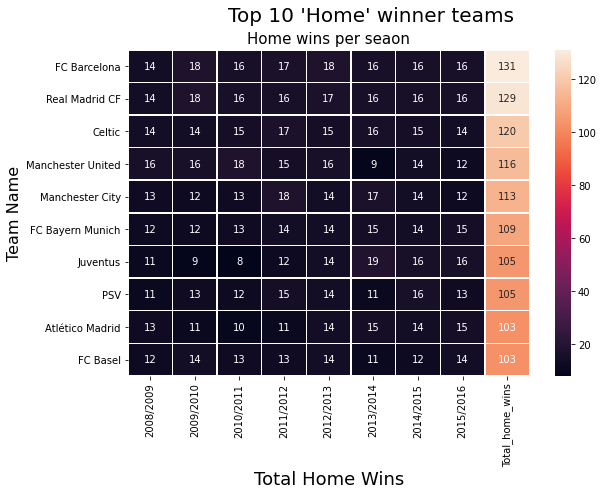

In [139]:
g, az = plt.subplots(figsize=(9, 6));
sns.heatmap(home_winner_v1_df.head(10), annot=True, fmt="d", linewidths=.5, ax=az);
plt.suptitle("Top 10 'Home' winner teams", fontsize=20);
plt.title("Home wins per seaon", fontsize=15);

plt.xlabel('Total Home Wins', fontsize=18);
plt.ylabel('Team Name', fontsize=16);
plt.show();

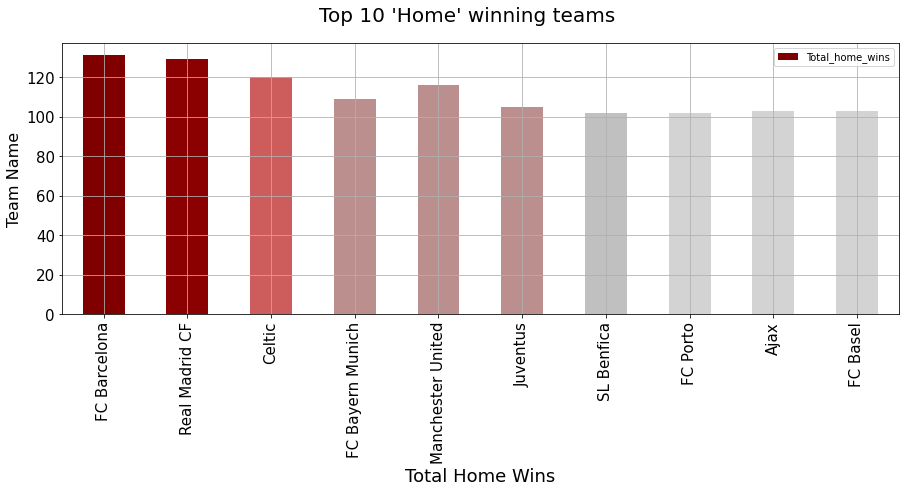

In [140]:
colors_home=  ['maroon','darkred','indianred','rosybrown','rosybrown','rosybrown','silver','lightgray','lightgrey','lightgrey']
top_winner_season_v2_df.plot(color=colors_home,x='Team Name',y='Total_home_wins', kind='bar', grid = True, fontsize = 15, figsize=(15,5));
plt.suptitle("Top 10 'Home' winning teams", fontsize=20);
plt.xlabel('Total Home Wins', fontsize=18);
plt.ylabel('Team Name', fontsize=16);
plt.show();

<h3><p style="color:darkred;">2-Who are the top 10 "Away" winning teams during the seasons [2008/2009] ~ [2015/2016] ?</p></h3> 

In [141]:
# away_winner_v1_df.head(10).style.highlight_max(color = 'lightgreen', axis = 0)

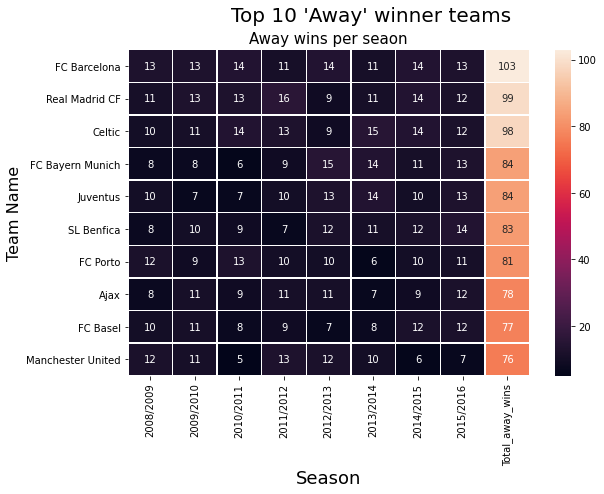

In [142]:
f, ax = plt.subplots(figsize=(9, 6));
sns.heatmap(away_winner_v1_df.head(10), annot=True, fmt="d", linewidths=.5, ax=ax);
plt.suptitle("Top 10 'Away' winner teams", fontsize=20);
plt.title("Away wins per seaon", fontsize=15);

plt.xlabel('Season', fontsize=18);
plt.ylabel('Team Name', fontsize=16);
plt.show();

### The above heatmap shows Real Madrid, Barcelona and Celtic kept winning away games more than any other team in europe

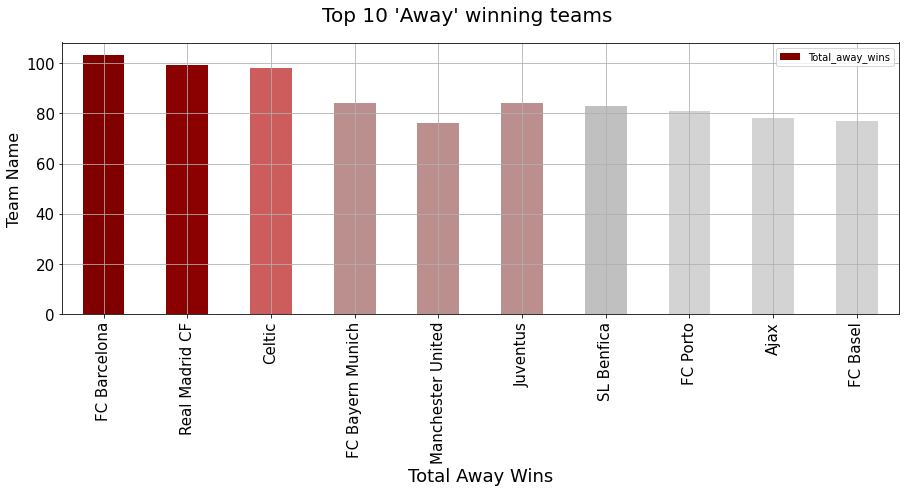

In [143]:
top_winner_season_v2_df.plot(color=['maroon','darkred','indianred','rosybrown','rosybrown','rosybrown','silver','lightgray','lightgrey','lightgrey'],x='Team Name', y='Total_away_wins', kind='bar', grid = True, fontsize = 15, figsize=(15,5));

plt.suptitle("Top 10 'Away' winning teams", fontsize=20);
plt.xlabel('Total Away Wins', fontsize=18);
plt.ylabel('Team Name', fontsize=16);
plt.show();

<h3><p style="color:darkred;">3-Who are the top 10 winners teams during the seasons [2008/2009] ~ [2015/2016] ?</p></h3> 

In [144]:
top_winner_season_v2_df.style.background_gradient(text_color_threshold=0.408)

,Team Name,Total_home_wins,Total_away_wins,Total_wins
0,FC Barcelona,131,103,234
1,Real Madrid CF,129,99,228
2,Celtic,120,98,218
3,FC Bayern Munich,109,84,193
4,Manchester United,116,76,192
5,Juventus,105,84,189
6,SL Benfica,102,83,185
7,FC Porto,102,81,183
8,Ajax,103,78,181
9,FC Basel,103,77,180


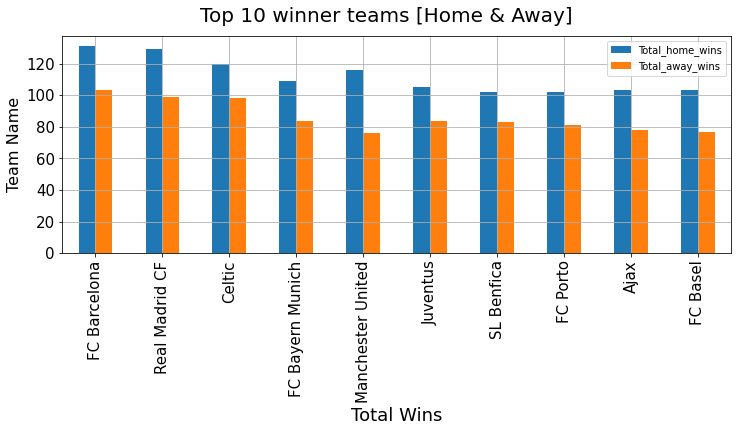

In [145]:
top_winner_season_v2_df.plot(x='Team Name', y=['Total_home_wins','Total_away_wins'], kind='bar', grid = True, fontsize = 15, figsize=(12,4));
plt.suptitle("Top 10 winner teams [Home & Away]", fontsize=20);
plt.xlabel('Total Wins', fontsize=18);
plt.ylabel('Team Name', fontsize=16);
plt.show();

## Real Madrid, Barcelona and Celtic (away wins) are high comparing to (home wins) of the rest of the top 10 winner teams, that means the top winners teams are keeping their winning rate high even in away matches.

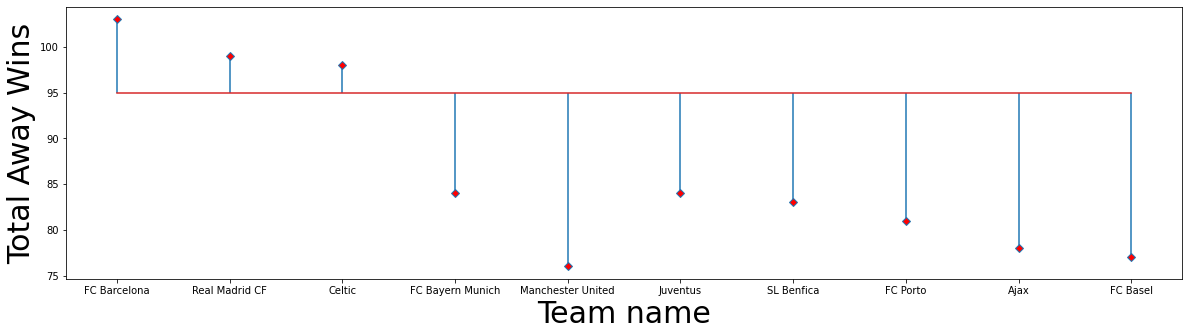

In [146]:
x=top_winner_season_v2_df['Team Name'].head(10)
y=top_winner_season_v2_df['Total_away_wins'].head(10)
plt.figure(figsize=(20,5))
markerline, stemlines, baseline = plt.stem(x, y, linefmt='D', markerfmt='D', bottom=95);
markerline.set_markerfacecolor('red')
plt.ylabel('Total Away Wins', fontsize = 30);
plt.xlabel('Team name', fontsize = 30);
plt.show();

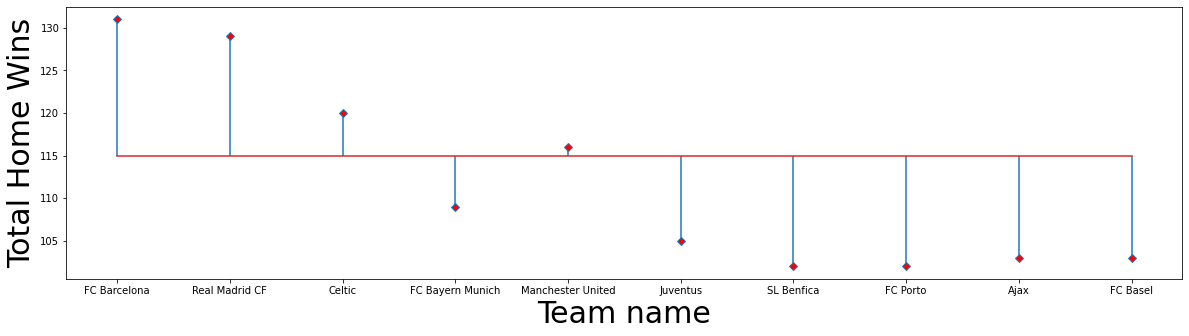

In [147]:
x=top_winner_season_v2_df['Team Name'].head(10)
y=top_winner_season_v2_df['Total_home_wins'].head(10)
plt.figure(figsize=(20,5))
markerline, stemlines, baseline = plt.stem(x, y, linefmt='D', markerfmt='D', bottom=115);
markerline.set_markerfacecolor('red')
plt.ylabel('Total Home Wins', fontsize = 30);
plt.xlabel('Team name', fontsize = 30);
plt.show();

## The above plot shows that Real Madrid, Barcelona and Celtic have more than 115 (Home) wins in total wins

### we noticed that Manchester United also break the 115 home wins, 
### however they still in the 5th rank as the ratio between their home and their away wins is higher than the 4th  team (Bayern Munich) home away wins ratio, as Bayern Munich have 84 away wins comparing to the 76 away wins of Man Utd. 

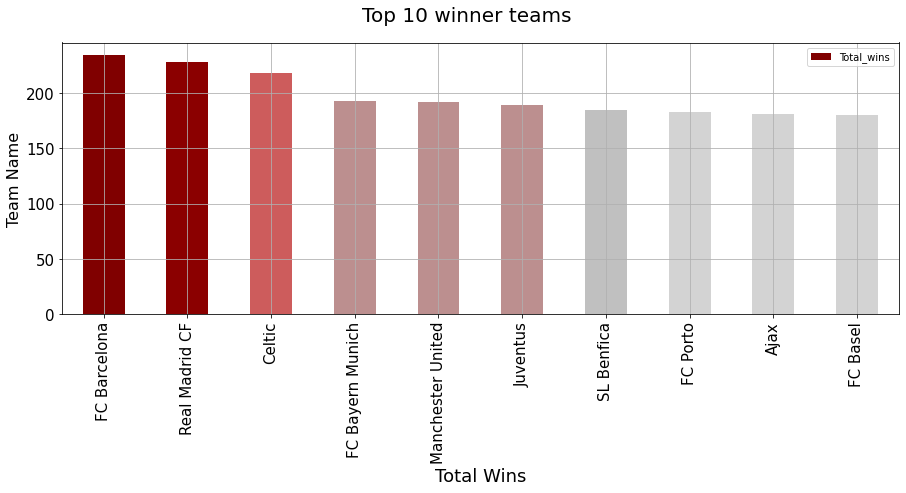

In [148]:
color_total= ['maroon','darkred','indianred','rosybrown','rosybrown','rosybrown','silver','lightgray','lightgrey','lightgrey']
top_winner_season_v2_df.plot(color=color_total,x='Team Name', y='Total_wins', kind='bar', grid = True, fontsize = 15, figsize=(15,5));
plt.suptitle("Top 10 winner teams", fontsize=20);
plt.xlabel('Total Wins', fontsize=18);
plt.ylabel('Team Name', fontsize=16);
plt.show();

### For more investigation in the factors of the winning rate we can analyze the scoring rate of the Top 10 winner teams to justify the relation between the scoring rate and the winning rate.

<h3><p style="color:darkred;">4-Who are the top 10 highest scoring teams during the seasons [2008/2009] ~ [2015/2016] ?</p></h3> 

In [149]:
top_scorer.style.background_gradient(text_color_threshold=0.408)

,Team Name,Total Goals
1,FC Barcelona,849
0,Real Madrid CF,843
2,Celtic,695
3,FC Bayern Munich,653
4,PSV,652
6,Ajax,647
7,FC Basel,619
5,Manchester City,606
9,Chelsea,583
8,Manchester United,582


In [150]:
total_goal_per_season_v1.style.background_gradient(text_color_threshold=0.500)

,Team Name,Total_wins,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
2,FC Barcelona,234,105,98,95,114,115,100,110,112
8,Real Madrid CF,228,83,102,102,121,103,104,118,110
1,Celtic,218,80,75,85,84,92,102,84,93
4,FC Bayern Munich,193,71,72,81,77,98,94,80,80
7,Manchester United,192,68,86,78,89,86,64,62,49
6,Juventus,189,69,55,57,64,71,80,72,75
9,SL Benfica,185,54,78,61,66,77,58,86,88
5,FC Porto,183,61,70,73,69,70,57,74,67
0,Ajax,181,74,106,72,93,83,69,69,81
3,FC Basel,180,72,90,76,78,61,70,84,88


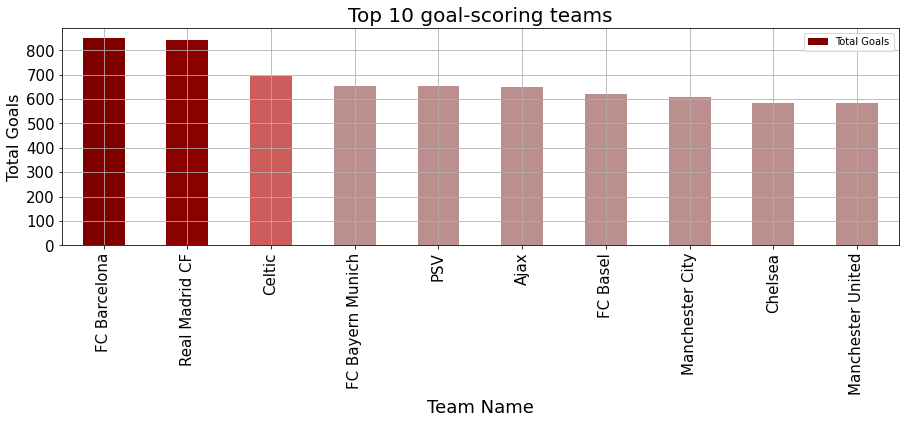

In [151]:
colors=['maroon','darkred','indianred','rosybrown','rosybrown','rosybrown','rosybrown','rosybrown','rosybrown','rosybrown','silver','lightgray','lightgrey','lightgrey','darksalmon']
top_scorer.plot(x='Team Name', y ='Total Goals', subplots=True,kind='bar', grid = True, fontsize = 15, figsize=(15,4), color=colors);
plt.title("Top 10 goal-scoring teams", fontsize=20);
plt.xlabel('Team Name', fontsize=18);
plt.ylabel('Total Goals', fontsize=16);
plt.show();

### It's clear that the top goal_scoring teams are:

## Real Madrid, Barcelona and Celtic

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


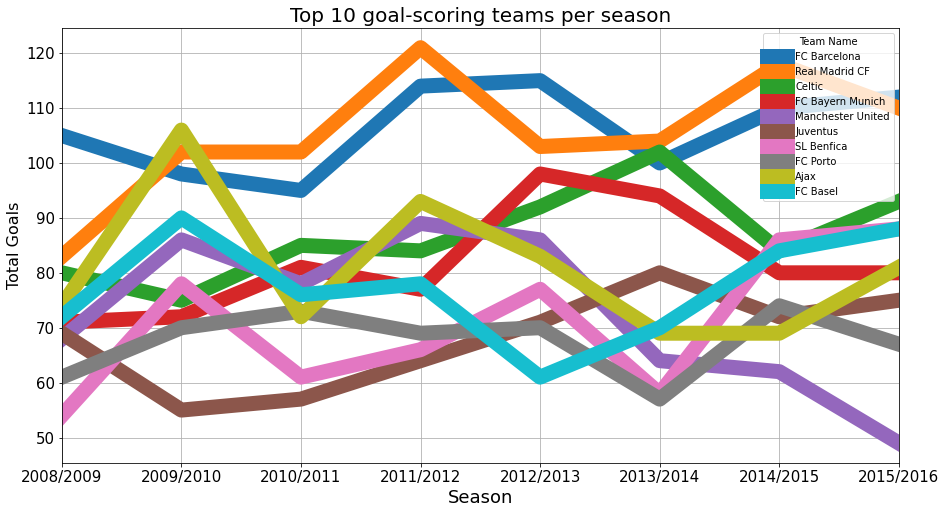

In [152]:
total_goal_per_season_v2.plot(grid= True, fontsize= 15, figsize=(15,8), linewidth = '15', ms = 10);
plt.title("Top 10 goal-scoring teams per season", fontsize=20);
plt.xlabel('Season', fontsize=18);
plt.ylabel('Total Goals', fontsize=16);
plt.show();

## FC Barcelona and Real Madrid CF kept their scoring rate higher than 90 goals per seaon during all the seasons which affected positively on their high winning rate in Home and Away matches during the same period

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


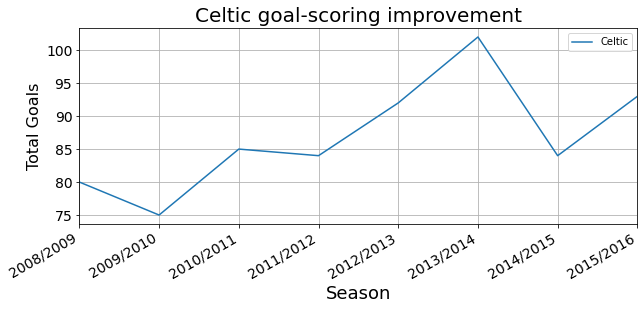

In [153]:
celtic_plot = total_goal_per_season_v2['Celtic'].reset_index()
celtic_plot.plot(subplots=True, x='index', y="Celtic", kind='line', grid = True, fontsize = 14, figsize=(10,4));
plt.title("Celtic goal-scoring improvement", fontsize=20);
plt.xlabel('Season', fontsize=18);
plt.ylabel('Total Goals', fontsize=16);
plt.show();

## we notice that Celtic goal-scoring improvement put them in the 3rd rank in the top 10 winner teams in same period 2008/2009 till 2015/2016

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


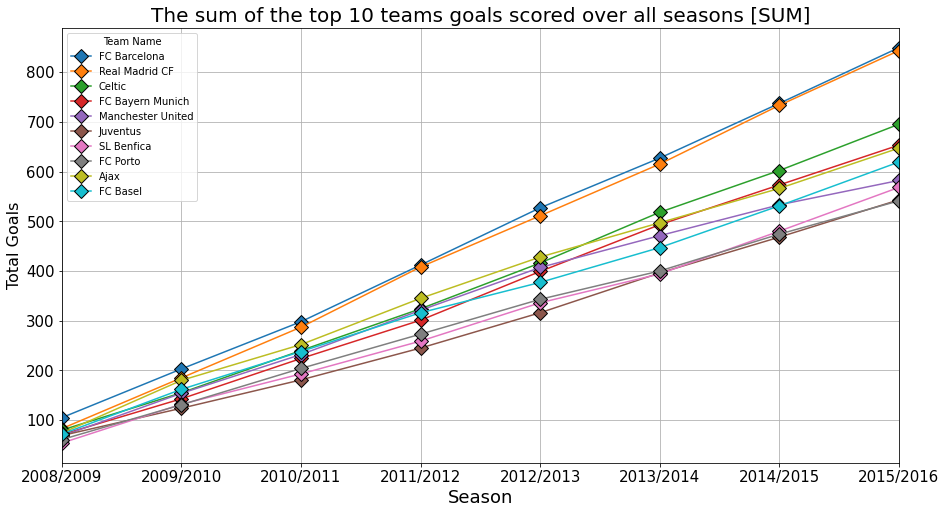

In [154]:
total_goals_sum.plot(grid = True, fontsize = 15, figsize=(15,8), marker='D', markeredgecolor='black', ms = 10);
plt.title("The sum of the top 10 teams goals scored over all seasons [SUM]", fontsize=20);
plt.xlabel('Season', fontsize=18);
plt.ylabel('Total Goals', fontsize=16);
plt.show();

## Real Madrid and Barcelona total goals is higher than any other top teams.

<h3><p style="color:darkred;">5-What's the top goal-scored league during the seasons [2008/2009] ~ [2015/2016] ?</p></h3> 


In [155]:
total_league_goals_df.style.background_gradient(text_color_threshold=0.408)

,League Name,Total Goals
0,Premier League,13044
1,LIGA BBVA,8412
2,Serie A,7895
3,Eredivisie,7542
4,Ligue 1,7427
5,1. Bundesliga,7103
6,Liga ZON Sagres,5201
7,Jupiler League,4841
8,Ekstraklasa,4656
9,Super League,4166


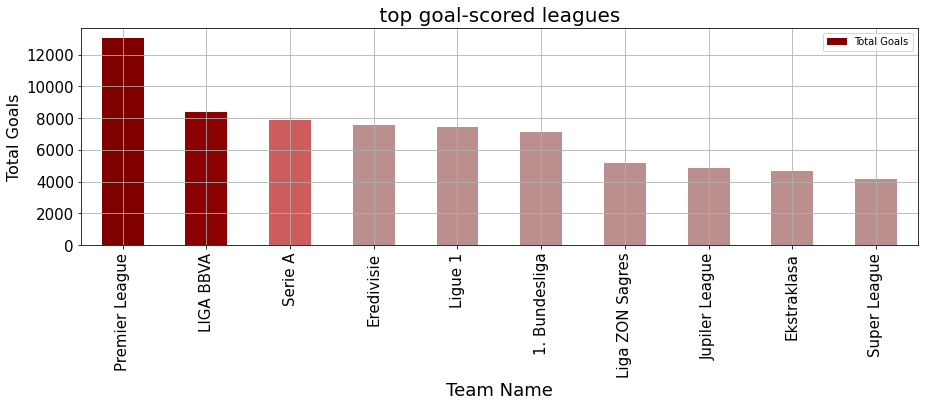

In [156]:
total_league_goals_df.plot(x='League Name', y ='Total Goals', subplots=True,kind='bar', grid = True, fontsize = 15, figsize=(15,4), color=colors);
plt.title(" top goal-scored leagues ", fontsize=20);
plt.xlabel('Team Name', fontsize=18);
plt.ylabel('Total Goals', fontsize=16);
plt.show();

## It's not surprising that LIGA BBVA comes 2nd in the top goal-scored leagues, for 2 reasons

### Real Madrid and Barcelona play in this league, but the rest of the league teams stats are lower than these two teams.
### on the other hand, the total goal-scored in the Premier League is obviously higher by at least 3k goals than LIGA BBVA .

### The previous conclusion indicate that the Premier League teams score a lot of goals but that dosen't mean they are top winner teams

### which lead us to scale up and ask what are the other team attributes that affect the winning rate.

<h3><p style="color:darkred;">6- What are the attributes of the top 10 winners teams ? </p> </h3>

### <p style="color:darkred;"> We will investigate the top teams attributes but we will consider the team attributes of Real Madrid (RM) and Barcelona(BAR) are the reference to have high socring rate and high winning rate </p>

<ul> 
    <li><h4>1- Team Defence  </h4>
        <ul>
            <li><h4>Pressure</h4></li>
            <li><h4>Team Width </h4></li>
            <li><h4>Agression </h4></li>
        </ul>
      </li>  
        <br>
    <li><h4>2- Team build-up play  </h4>
        <ul>
            <li><h4> Passing  </h4></li>
            <li><h4>Positioning </h4></li>
            <li><h4>Dribbling </h4></li>
        </ul>             
     </li>
    <li><h4>3- Team chance creation </h4>
        <ul>
            <li><h4>Crossing </h4></li>
            <li><h4>Shooting </h4></li>
            <li><h4> Passing  </h4></li>
        </ul>              
     </li>
</ul>

### 1- Team Defence

###### a- Pressure

In [157]:
team_att_pressure_v2_df.style.background_gradient(text_color_threshold=0.408)

,Team Name,Total_wins,Deep,High,Medium
0,FC Barcelona,234,0,68,62
1,Real Madrid CF,228,0,68,48
2,Celtic,218,0,0,53
3,FC Bayern Munich,193,0,71,50
4,Manchester United,192,0,0,45
5,Juventus,189,23,0,48
6,SL Benfica,185,30,0,59
7,FC Porto,183,30,0,58
8,Ajax,181,30,68,64
9,FC Basel,180,0,0,47


### Again we can see the differnece between RM and BAR and the rest of the top teams in "mean defence pressure":



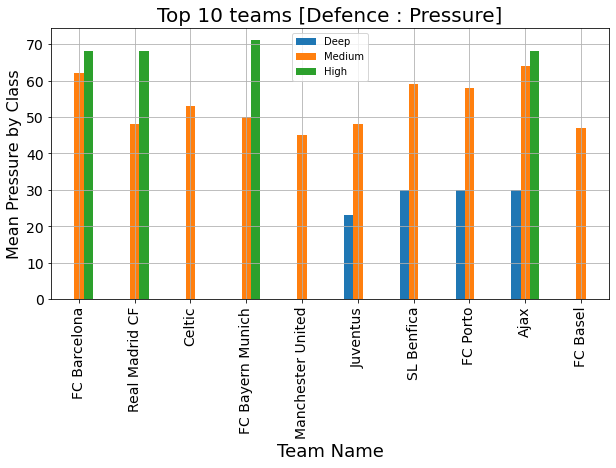

In [158]:
team_att_pressure_v1_df.plot(x='Team Name', y=['Deep','Medium','High'], kind='bar', grid = True, fontsize = 14, figsize=(10,5));
plt.title("Top 10 teams [Defence : Pressure]", fontsize=20);
plt.xlabel('Team Name', fontsize=18);
plt.ylabel('Mean Pressure by Class', fontsize=16);
plt.show();

#### RM and BAR rely in their defence pressure on high pressure. 

###### b- Team Width

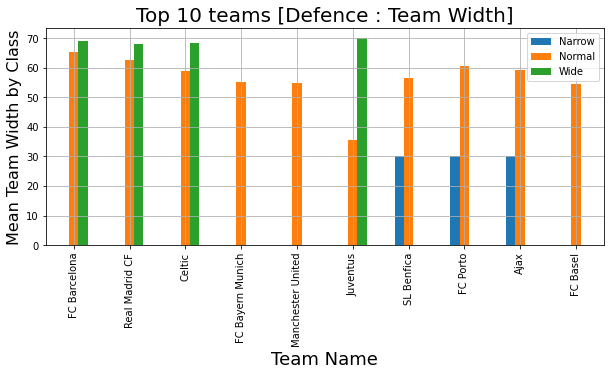

In [159]:
team_att_teamwidth_v1_df.plot(x='team_long_name', y=['Narrow','Normal','Wide'], kind='bar', grid = True, fontsize = 10, figsize=(10,4));
plt.title("Top 10 teams [Defence : Team Width]", fontsize=20);
plt.xlabel('Team Name', fontsize=18);
plt.ylabel('Mean Team Width by Class', fontsize=16);
plt.show();

#### RM, BAR and Celtic rely in their defence (Team Width) on "wide" width. 

###### c- Team aggression

In [160]:
team_att_aggression_v3_df.sort_values(by='Total_wins', ascending=False).style.background_gradient(text_color_threshold=0.408)

,Team Name,Total_wins,Contain,Double,Press
0,FC Barcelona,234,30,0,59
1,Real Madrid CF,228,0,0,52
2,Celtic,218,0,70,51
3,FC Bayern Munich,193,0,0,48
4,Manchester United,192,0,0,48
5,Juventus,189,0,67,52
6,SL Benfica,185,30,0,55
7,FC Porto,183,30,0,54
8,Ajax,181,30,0,58
9,FC Basel,180,0,0,57


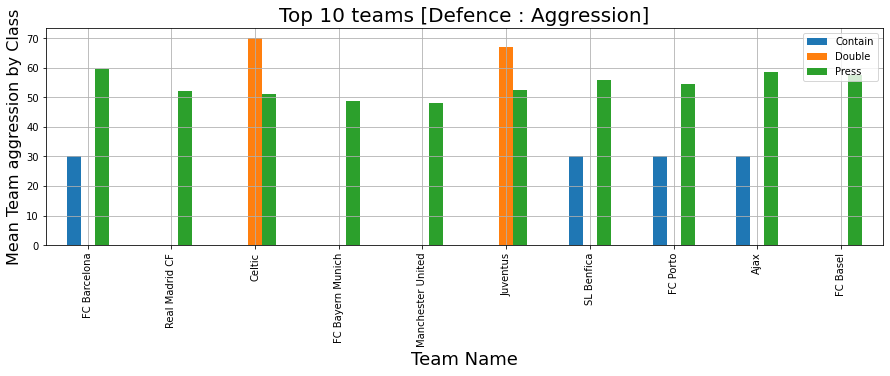

In [161]:
team_att_aggression_v1_df.plot(x='team_long_name', y=['Contain','Double','Press'], kind='bar', grid = True, fontsize = 10, figsize=(15,4)).axes.autoscale_view();
plt.title("Top 10 teams [Defence : Aggression]", fontsize=20);
plt.xlabel('Team Name', fontsize=18);
plt.ylabel('Mean Team aggression by Class', fontsize=16);
plt.show();

#### Most of the top teams rely on pressing the opponent and filling the spaces

### 2- Team build-up play

###### a- Passing

In [162]:
team_att_passing_v3_df.style.background_gradient(text_color_threshold=0.408)

,Team Name,Total_wins,Long,Mixed,Short,Total Passes
0,FC Barcelona,234,16,42.5,29.75,88.25
1,Real Madrid CF,228,16,40.4,30,86.4
2,Celtic,218,70,54.8,16,140.8
3,FC Bayern Munich,193,16,40.25,25,81.25
4,Manchester United,192,16,45.8333,16,77.8333
5,Juventus,189,16,40,25.6667,81.6667
6,SL Benfica,185,16,48.6,30,94.6
7,FC Porto,183,16,52.4,30,98.4
8,Ajax,181,16,38.5,31.5,86
9,FC Basel,180,16,44.8333,16,76.8333


/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:3

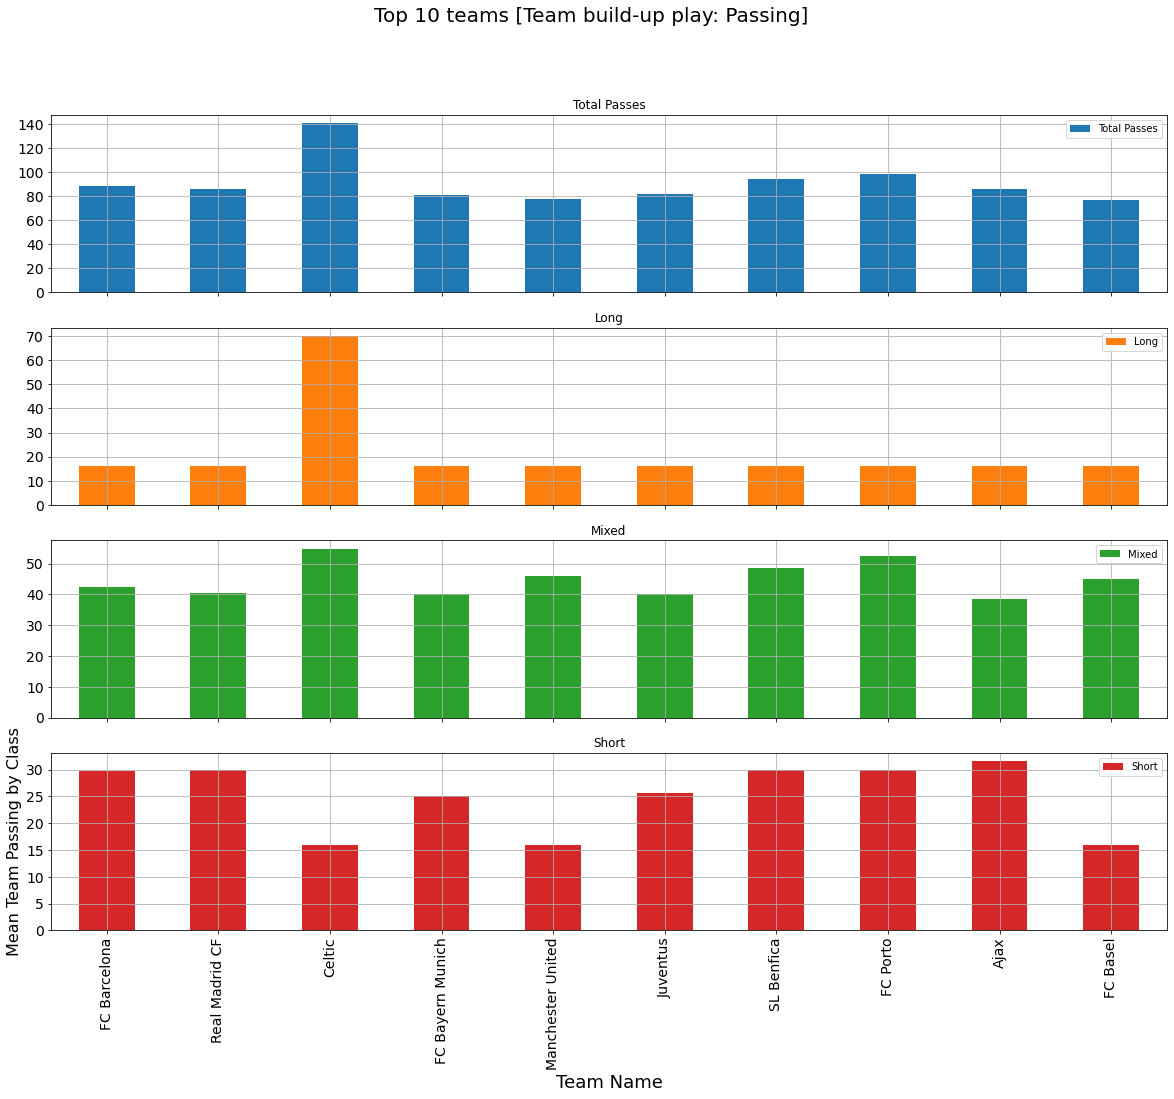

In [163]:
team_att_passing_v1_df.plot(subplots=True, x='team_long_name', y=['Total Passes','Long','Mixed','Short'], kind='bar', grid = True, fontsize = 14, figsize=(20,15));
plt.suptitle("Top 10 teams [Team build-up play: Passing]", fontsize=20);
plt.xlabel('Team Name', fontsize=18);
plt.ylabel('Mean Team Passing by Class', fontsize=16);
plt.show();

### Real Madrid and Barcelona rely on short passes, but on the other hand, Celtic rely more on the long passes 
### we can suggest that the teams with better player quality they rely on short passes more than the long passes

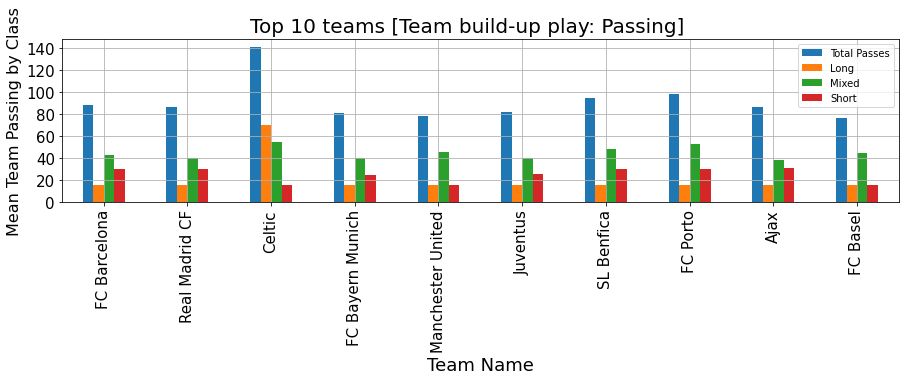

In [164]:
team_att_passing_v1_df.plot(x='team_long_name', y=['Total Passes','Long','Mixed','Short'], kind='bar', grid = True, fontsize = 15, figsize=(15,3));
plt.suptitle("Top 10 teams [Team build-up play: Passing]", fontsize=20);
plt.xlabel('Team Name', fontsize=18);
plt.ylabel('Mean Team Passing by Class', fontsize=16);
plt.show();

###### b- Dribbling

In [165]:
team_dribbling_v3_df.style.background_gradient(text_color_threshold=0.400)

,Team Name,Total_wins,Little,Normal
0,FC Barcelona,234,16,35
1,Real Madrid CF,228,16,55.5
2,Celtic,218,16,50.5
3,FC Bayern Munich,193,17.6,34
4,Manchester United,192,16,38
5,Juventus,189,16,41
6,SL Benfica,185,16,55
7,FC Porto,183,16,50
8,Ajax,181,16,41.5
9,FC Basel,180,16,63


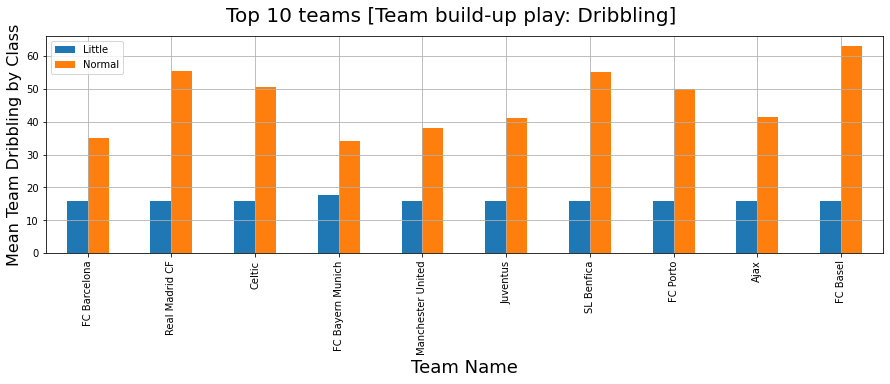

In [166]:
team_dribbling_v3_df.plot(x='Team Name', y=['Little','Normal'], kind='bar', grid = True, fontsize = 10,figsize=(15,4));
plt.suptitle("Top 10 teams [Team build-up play: Dribbling]", fontsize=20);
plt.xlabel('Team Name', fontsize=18);
plt.ylabel('Mean Team Dribbling by Class', fontsize=16);
plt.show();

### Real Madrid and Barcelona rely on dribbling is normal as they don't need to dribble a lot with the passing records they have but still they are relying on dribbling comparing to other top teams

###### c- Positioning

In [167]:
att_positioning_v2_df.style.background_gradient(text_color_threshold=0.5)

,Team Name,Total_wins,Free Form,Organised
0,FC Barcelona,234,6,0
1,Real Madrid CF,228,4,2
2,Celtic,218,0,6
3,FC Bayern Munich,193,3,3
4,Manchester United,192,0,6
5,Juventus,189,1,5
6,SL Benfica,185,2,4
7,FC Porto,183,1,5
8,Ajax,181,3,3
9,FC Basel,180,0,6


/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:3

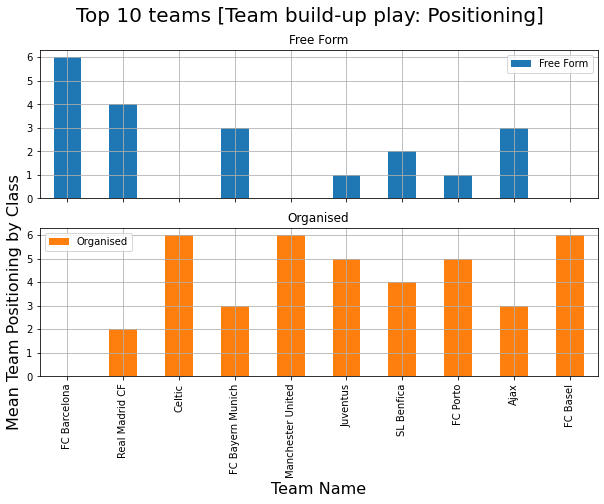

In [168]:
att_positioning_v2_df.plot(subplots=True, x='Team Name', y=['Free Form','Organised'], kind='bar', grid = True, fontsize = 10, figsize=(10,6));
plt.suptitle("Top 10 teams [Team build-up play: Positioning]", fontsize=20, va='top' );
plt.xlabel('Team Name', fontsize=16);
plt.ylabel('Mean Team Positioning by Class', fontsize=16);
plt.show();

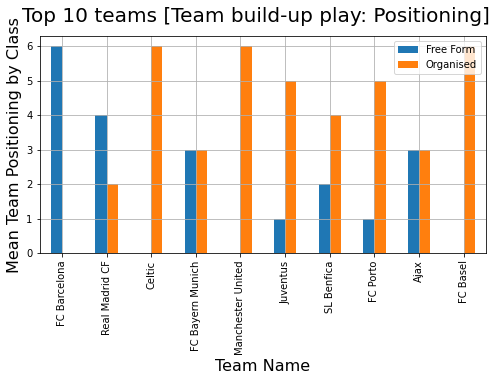

In [169]:
att_positioning_v2_df.plot(x='Team Name', y=['Free Form','Organised'], kind='bar', grid = True, fontsize = 10, figsize=(8,4));
plt.suptitle("Top 10 teams [Team build-up play: Positioning]", fontsize=20, va='top' );
plt.xlabel('Team Name', fontsize=16);
plt.ylabel('Mean Team Positioning by Class', fontsize=16);
plt.show();

### Real Madrid and Barcelona positioning is different than all the top teams as they rely on free form of building up play, it's not weird as they have the quality of players that can apply this kind of build up play

### 2- Chance Creation 

###### A- by Crossing

In [170]:
team_crossing_v2_df.style.background_gradient(text_color_threshold=0.400)

,Team Name,Total_wins,Little,Normal,Lots
0,FC Barcelona,234,27.75,44.5,16
1,Real Madrid CF,228,16,53.8333,16
2,Celtic,218,16,57,68.5
3,FC Bayern Munich,193,30.6667,41,70
4,Manchester United,192,16,56.3333,70
5,Juventus,189,16,57.2,77
6,SL Benfica,185,16,59,16
7,FC Porto,183,16,64.25,72
8,Ajax,181,16,58.5,16
9,FC Basel,180,16,63.8333,16


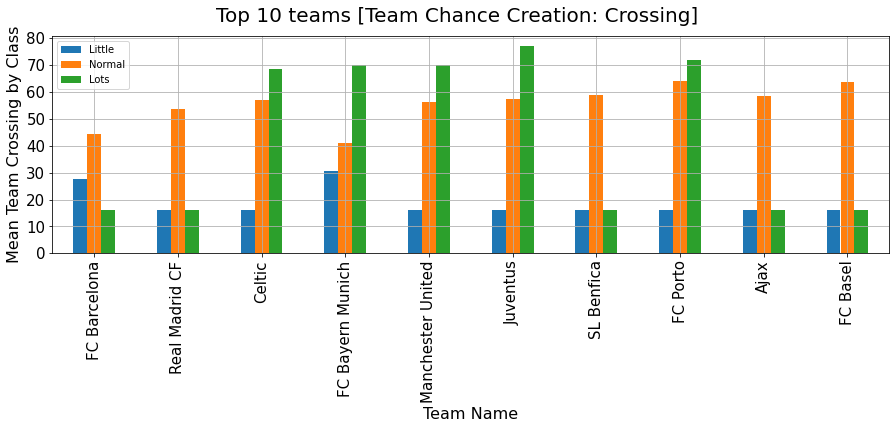

In [171]:
team_crossing_v2_df.plot(x='Team Name', y=['Little','Normal','Lots'], kind='bar', grid = True, fontsize = 15, figsize=(15,4));
plt.suptitle("Top 10 teams [Team Chance Creation: Crossing]", fontsize=20, va='top' );
plt.xlabel('Team Name', fontsize=16);
plt.ylabel('Mean Team Crossing by Class', fontsize=16);
plt.show();

### Creating chances by crossing isn't the main weapon for Real Mardid and Barcelona in scoring goals, eventhough they have normal mean of crosses copmaring to other top teams

###### b- by Shooting

In [172]:
team_shooting_v3_df.style.background_gradient(text_color_threshold=0.45)

,Team Name,Total_wins,Little,Normal,Lots
0,FC Barcelona,234,16,45,69
1,Real Madrid CF,228,16,63,70
2,Celtic,218,16,59,70
3,FC Bayern Munich,193,22,44,71
4,Manchester United,192,16,50,70
5,Juventus,189,16,50,73
6,SL Benfica,185,16,55,16
7,FC Porto,183,16,62,68
8,Ajax,181,30,43,68
9,FC Basel,180,16,52,16


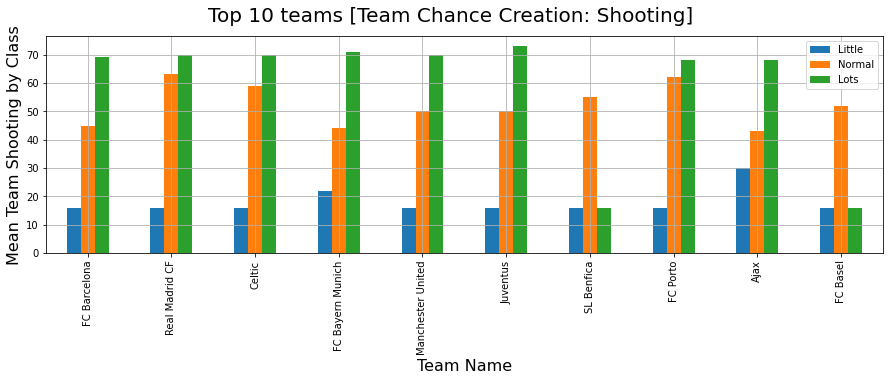

In [173]:
team_shooting_v3_df.plot(x='Team Name', y=['Little','Normal','Lots'], kind='bar', grid = True, fontsize = 10, figsize=(15,4));

plt.suptitle("Top 10 teams [Team Chance Creation: Shooting]", fontsize=20, va='top' );
plt.xlabel('Team Name', fontsize=16);
plt.ylabel('Mean Team Shooting by Class', fontsize=16);
plt.show();

#### It's obvious that top teams including Real Madrid and Barcelona rely more on shooting to score goals as their main weapon for their high scoring records.

###### c- Passing

In [174]:
team_att_chance_passing_v3_df.style.background_gradient(text_color_threshold=0.45)

,Team Name,Total_wins,Safe,Normal,Risky,Total Passes
0,FC Barcelona,234,16,45,16,77
1,Real Madrid CF,228,16,61,68,145
2,Celtic,218,16,55,16,87
3,FC Bayern Munich,193,21,42,16,79
4,Manchester United,192,16,50,16,82
5,Juventus,189,16,56,16,88
6,SL Benfica,185,16,61,69,146
7,FC Porto,183,16,55,16,87
8,Ajax,181,16,47,67,130
9,FC Basel,180,16,60,16,92


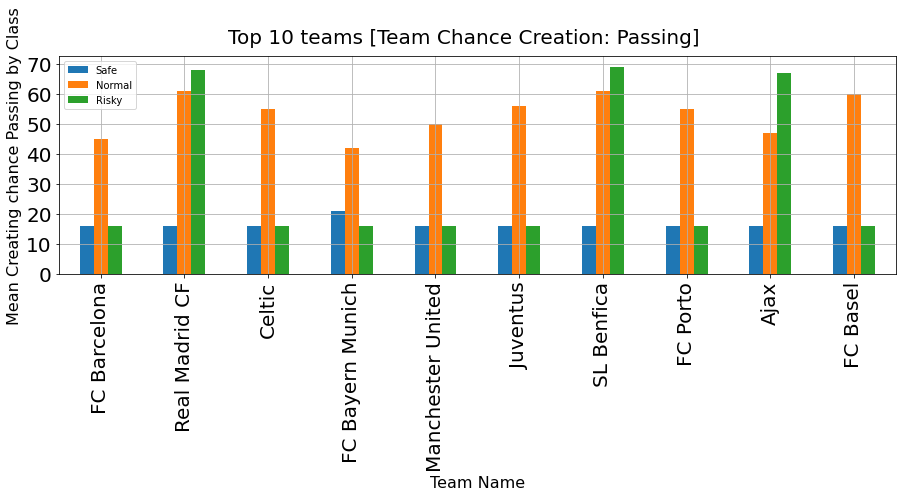

In [187]:
team_att_chance_passing_v3_df.plot(x='Team Name', y=['Safe','Normal','Risky'], kind='bar', grid = True, fontsize = 20, figsize=(15,4));

plt.suptitle("Top 10 teams [Team Chance Creation: Passing]", fontsize=20, va='top' );
plt.xlabel('Team Name', fontsize=16);
plt.ylabel('Mean Creating chance Passing by Class', fontsize=16);
plt.show();

#### Real Madrid and Barcelona are different in this plot as Real Madrid rely on Risky passes for creating scoring chances,
#### and for Barcelona they rely on normal passes.
#### but we have a prediction here based on Real Madrid rely on risky passes to be delivered to their top star C.Ronaldo in the attacking areas, Barcelona build their scoring chances on Messi's short passes.

<h3><p style="color:darkred;">7- Who are the Top 10 players that affecting the top 10 winners teams attributes ? </p> </h3>

##### After investigating previous questions we can answer this question in two part based on the top winner and scorer teams :
<br>
<br>

	
#### Top teams in both  winning and scoring goals and it will be our refrence in the other attributes:
##### 1- FC Barcelona
##### 2- Real Madrid CF
##### 3- Celtic
<br><br><br>
<h2>For each attributes I will mention the results for each attributes preferred by the top teams:<h2>
<h3>1- Team Defence </h3>
    <p><h5> Pressure : Medium & High </h5>
    <h5> Team Width : Normal & Wide </h5>
    <h5> Agression : Press </h5></p>
      <br><br>  
<h3>2- Team build-up play </h3>
    <p>
    <h5>Passing : Mixed & Short </h5>
    <h5>Positioning : Normal & Wide </h5>
    <h5>Dribbling : Normal </h5></p>

<br><br>
<h3>3- Team chance creation:</h3>
<p><br>
<h5>Crossing : Normal</h5>
<h5>Shooting : Lots</h5>
<h5>Passing : Normal & Risky </h5>
</p>
<br><br><br>
<h4> That means the teams with high scoring rate are the teams that apply high pressure with stretching the field </h4>
<h4> Plus in the transformation in attack they have more passing and shooting rates </h4>
  

<h3>  
  and for the Top players per skill and they are playing in the top 10 teams and affecting on the team attributes to help in winning and scoring :
</h3>  

<h4>Top Defender are :</h4>


In [176]:
df_defender.head(10).style.background_gradient(text_color_threshold=0.408)

,interceptions,sliding_tackle,standing_tackle,marking,Overall Defending
player_name,,,,,
Javier Mascherano,90.7059,88.8824,90.8824,82.8235,90.3382
Philipp Lahm,89.7727,94.3636,87.4545,85.6364,89.7614
Carles Puyol,90.0909,89.1818,89.6364,90.6364,89.6364
Giorgio Chiellini,86.8276,88.3448,88.7586,88.4828,88.1724
John Terry,85,85.5625,89.625,87.375,87.4531
Sergio Ramos,83.4286,89,87.7857,85,87
Andrea Barzagli,87.7419,84.8065,87.2258,86.6129,86.75
Thiago Silva,83.8947,88.2632,87.0526,85.3684,86.5658
Gennaro Gattuso,84.3846,85.6923,87.3077,79.6154,86.1731


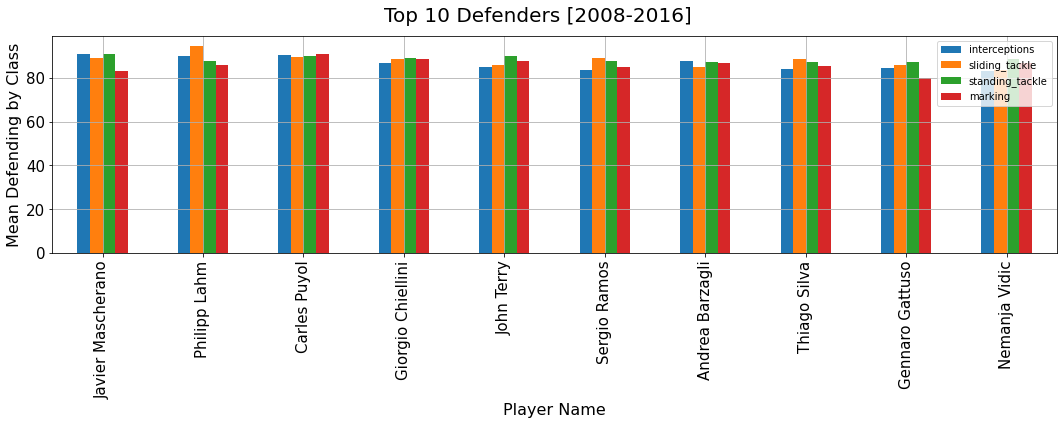

In [177]:
df_defender_v1.plot(x='player_name', y=['interceptions','sliding_tackle','standing_tackle','marking'], kind='bar', grid = True, fontsize = 15, figsize=(18,4));
plt.suptitle("Top 10 Defenders [2008-2016]", fontsize=20, va='top' );
plt.xlabel('Player Name', fontsize=16);
plt.ylabel('Mean Defending by Class', fontsize=16);
plt.show();

<h4>Top Build-up players are :</h4>


In [178]:
df_buildUp.head(10).style.background_gradient(text_color_threshold=0.408)

,short_passing,long_passing,positioning,Overall Build_up
player_name,,,,
Xavi Hernandez,95.1429,92.0714,88.1429,91.7857
Cesc Fabregas,92.913,91.5652,86.913,90.4638
Andres Iniesta,93.6667,89.1333,88,90.2667
Paul Scholes,91.1,90.5,88.4,90
Xabi Alonso,89.9091,92.4545,82.3636,88.2424
Michael Ballack,87.8,86.6,86.7,87.0333
Francesco Totti,90.9286,87.2143,81.8214,86.6548
Ivan de la Pena,91.25,90.625,76.875,86.25
Jose Maria Guti,89.875,86.875,81.875,86.2083


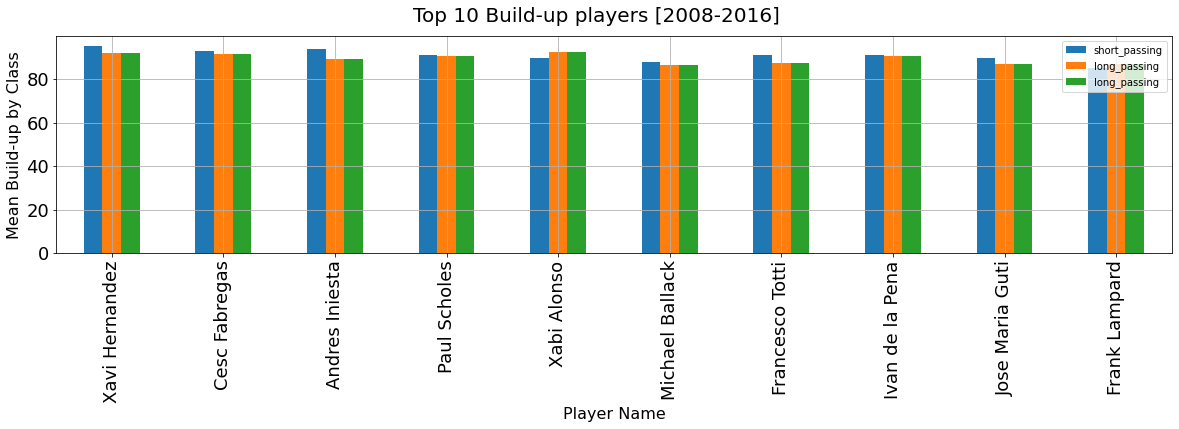

In [179]:
df_buildUp_v1.plot(x='player_name', y=['short_passing','long_passing','long_passing'], kind='bar', grid = True, fontsize = 18, figsize=(20,4));
plt.suptitle("Top 10 Build-up players [2008-2016]", fontsize=20, va='top' );
plt.xlabel('Player Name', fontsize=16);
plt.ylabel('Mean Build-up by Class', fontsize=16);
plt.show();

<h4>Top Scorer players are :</h4>


In [180]:
df_scorer.head(10).style.background_gradient(text_color_threshold=0.408)


,heading_accuracy,shot_power,long_shots,finishing,Overall Scoring
player_name,,,,,
Cristiano Ronaldo,85.1333,91.8667,87.8,89.5333,88.5833
Didier Drogba,91.3333,90.1667,80.9444,87.4444,87.4722
Michael Ballack,91.8,89.2,87.2,79.9,87.025
Zlatan Ibrahimovic,79.3684,91.7895,86.4211,89.7895,86.8421
Wayne Rooney,77.5714,90.5714,85.619,88.7143,85.619
Oscar Cardozo,81.8148,89.037,82.8519,85.1111,84.7037
David Villa,74.125,86.6875,85.375,90.125,84.0781
Robin van Persie,72.4545,89.6364,84.6818,88.1818,83.7386
Steven Gerrard,74.0833,92.9583,87,80.4167,83.6146


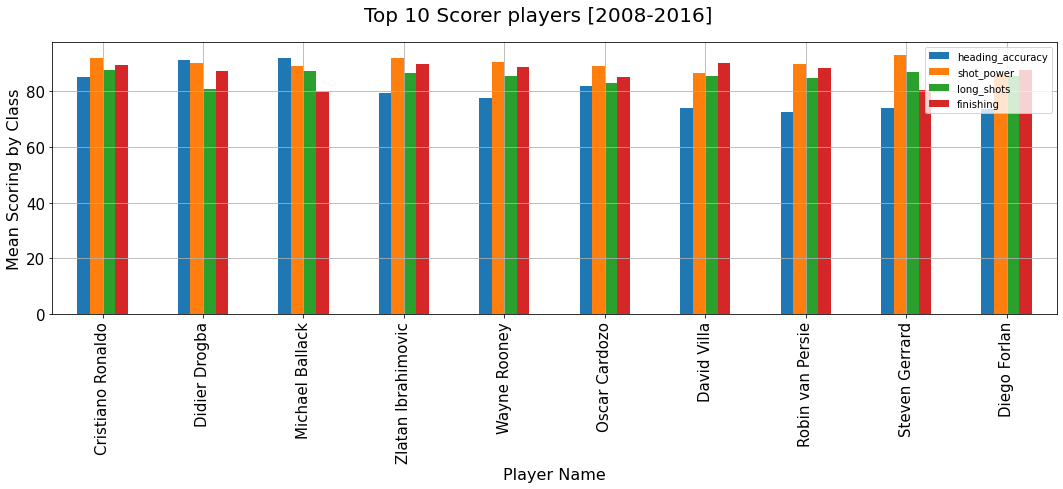

In [181]:
df_scorer_v1.plot(x='player_name', y=['heading_accuracy','shot_power','long_shots','finishing'], kind='bar', grid = True, fontsize = 15, figsize=(18,5));
plt.suptitle("Top 10 Scorer players [2008-2016]", fontsize=20, va='top' );
plt.xlabel('Player Name', fontsize=16);
plt.ylabel('Mean Scoring by Class', fontsize=16);
plt.show();

<h4>Top Dribbler players are :</h4>


In [182]:
df_Dribbler.head(10).style.background_gradient(text_color_threshold=0.408)

,dribbling,ball_control,Overall Dribbling
player_name,,,
Lionel Messi,96.5,95.625,96.0625
Cristiano Ronaldo,93.4,94.4,93.9
Franck Ribery,92.7778,91.3333,92.0556
Ronaldinho,90.5,93.4444,91.9722
Arjen Robben,92.5263,89.5263,91.0263
Neymar,91.8333,90.1667,91
Andres Iniesta,89.4667,92.4,90.9333
Zlatan Ibrahimovic,89.2105,91.1053,90.1579
Sergio Aguero,90.56,89.36,89.96


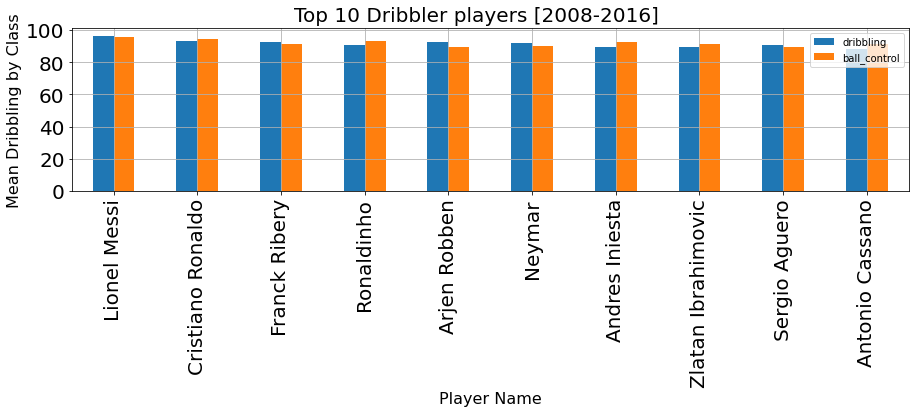

In [183]:

df_Dribbler_v1 = df_Dribbler.head(10).reset_index()
df_Dribbler_v1.plot(x='player_name', y=['dribbling','ball_control'], kind='bar', grid = True, fontsize = 20, figsize=(15,3));
plt.suptitle("Top 10 Dribbler players [2008-2016]", fontsize=20, va='top' );
plt.xlabel('Player Name', fontsize=16);
plt.ylabel('Mean Dribbling by Class', fontsize=16);
plt.show();

<h4>Top Overall players are: </h4>


In [184]:
top_overall_rating_df_v1 = top_overall_rating_df.head(10).reset_index()
top_overall_rating_df_v1.style.background_gradient(text_color_threshold=0.408)


,player_name,overall_rating
0,Lionel Messi,91.3125
1,Cristiano Ronaldo,90.6667
2,Franck Ribery,88.2778
3,Zlatan Ibrahimovic,88.2105
4,Andres Iniesta,87.8
5,Arjen Robben,87.7895
6,Xavi Hernandez,87.7143
7,Wayne Rooney,87.619
8,Iker Casillas,87.3571
9,Carles Puyol,86.7273


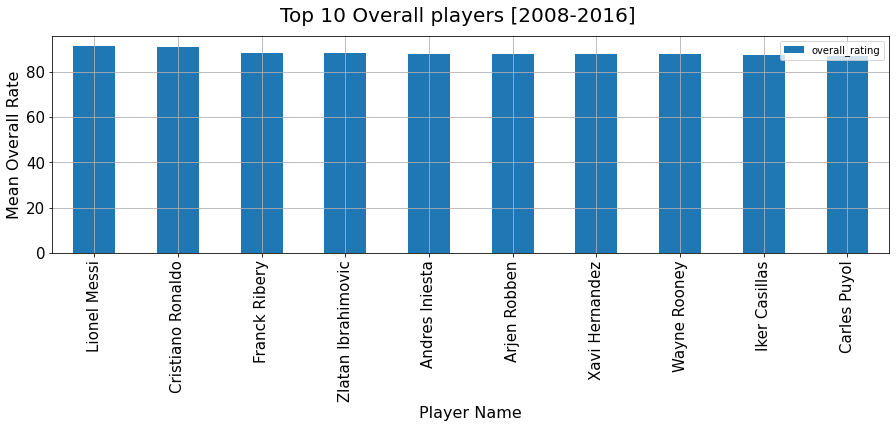

In [185]:
top_overall_rating_df_v1.plot(x='player_name', y='overall_rating', kind='bar', grid = True, fontsize = 15, figsize=(15,4));
plt.suptitle("Top 10 Overall players [2008-2016]", fontsize=20, va='top' );
plt.xlabel('Player Name', fontsize=16);
plt.ylabel('Mean Overall Rate', fontsize=16);
plt.show();

#### Based on our investigation for the top players in many aspects it's clear why teams like Real Madrid and Barcelona have this high stats of winning and scoring goals due to the presence of the top 2 players between their squad



## Limitation section:

#### we faced a limitation in the datasets that the players stats has no relation with the teams stats
#### this is why we used https://www.transfermarkt.com/ website to get the teams of each player of the top players to know if they plays for Real Madrid and Barcelona 

##### https://www.transfermarkt.com/cristiano-ronaldo/profil/spieler/8198  C.Ronaldo
##### https://www.transfermarkt.com/lionel-messi/profil/spieler/28003 L.Messi